<a href="https://colab.research.google.com/github/brenoakihiromorimoto/portf-lio/blob/main/portf-lio/IFOOD/Ifood_marketing_parte_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importar bibliotecas

In [4]:
!pip install dython
!pip install scipy
!pip install kmodes
!pip install yellowbrick
!pip install matplotlib==3.1.3

  Using cached matplotlib-3.5.2-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.whl (11.2 MB)
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.1.3
    Uninstalling matplotlib-3.1.3:
      Successfully uninstalled matplotlib-3.1.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


  Using cached matplotlib-3.1.3-cp37-cp37m-manylinux1_x86_64.whl (13.1 MB)
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.5.2
    Uninstalling matplotlib-3.5.2:
      Successfully uninstalled matplotlib-3.5.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dython 0.7.1.post3 requires matplotlib>=3.4.3, but you have matplotlib 3.1.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.cluster import MeanShift, KMeans
from statistics import mode
from scipy.stats import shapiro, mannwhitneyu, ttest_ind, levene, chi2_contingency
from sklearn.cluster import KMeans 
from kmodes.kprototypes import KPrototypes 
from sklearn.preprocessing import RobustScaler
import matplotlib.pyplot as plt
from matplotlib import cm
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from mlxtend.preprocessing import TransactionEncoder
import statsmodels.formula.api as smf
import scipy
from dython.nominal import associations

from scipy.stats import zscore

from statsmodels.stats.stattools import durbin_watson

# Baixar dataset pelo Drive

In [6]:
!gdown "1gnp0UlZ4csabiwdVgM5DdtdsFkbK9gQG"

Downloading...
From: https://drive.google.com/uc?id=1gnp0UlZ4csabiwdVgM5DdtdsFkbK9gQG
To: /content/ml_project1_data.csv
100% 220k/220k [00:00<00:00, 80.5MB/s]


In [7]:
df_marketing = pd.read_csv("/content/ml_project1_data.csv")

# Funções

In [8]:
def hypothesis_test(group_A, group_B):
  stats_group_a, p_group_a = shapiro(group_A)
  stats_group_b, p_group_b = shapiro(group_B)
  print('Teste de Shapiro-Wilk: valor-p do grupo A: %.3f, valor-p do Grupo B: %.3f.' % (p_group_a, p_group_b))
  if p_group_a>=0.05 and p_group_b>=0.05:
    stats_levene, p_levene = levene(group_A,
                     group_B)
    print('O Teste de Shapiro-Wilk demonstrou que os grupos têm distribuição normal dos dados.')
    print('Teste de Levene: stats: %.3f, valor-p: %.3f.' % (stats_levene, p_levene))
    if p_levene>=0.05:
      stats_ttest, p_ttest = ttest_ind(group_A,
                          group_B, equal_var=True)
      print(f"O teste de Levene demonstrou que a variância é igual nos dois grupos: p-valor de %.3f." % (p_levene))

      print('Teste-t independente: stats: %.3f, valor-p: %.3f.' % (stats_ttest, p_ttest))
    elif p_levene<0.05:
      stats_ttest, p_ttest = ttest_ind(group_A,
                          group_B, equal_var=False)
      
      print(f"O teste de Levene demonstrou que a variância é significantemente diferente nos dois grupos: p-valor de %.3f." % (p_levene))
      if p_ttest>=0.05:
        print(f"O teste-t independente demonstrou diferença significativa das médias dos dois grupos: p-valor de %.3f." % (p_ttest))
      elif p_ttest<0.05:
        print(f"O teste-t independente não demonstrou diferença significativa das médias dos dois grupos: p-valor de %.3f." % (p_ttest))
  elif p_group_a<0.05 or p_group_b<0.05:
    stats_mann, p_mann = mannwhitneyu(group_A, group_B)
    print('O Teste de Shapiro-Wilk demonstrou que, no mínimo, algum dos dois grupos não tem distribuição normal dos dados.')
    print('Teste de Mann-Whitney-U: stats: %.3f, valor-p: %.3f.' % (stats_mann, p_mann))
    if p_mann>=0.05:
      print("O teste Mann-Whitney-U não demonstrou diferença significativa das medianas dos dois grupos: p-valor de %.3f." % (p_mann))
    elif p_mann<0.05:
      print("O teste Mann-Whitney-U demonstrou diferença significativa das medianas dos dois grupos: p-valor de %.3f." % (p_mann))

def plot_residuals_series(df_marketing_EDA_02, results):
  fig = plt.figure(figsize=(15,10))
  ax = fig.add_subplot(title="Residual Series Plot",
                      xlabel="Index Number", 
                      ylabel="Deviance Residuals")
  ax.plot(df_marketing_EDA_02.index.tolist(), 
          zscore(results.resid_dev))

# EDA 01

In [9]:
df_marketing_EDA_01 = df_marketing.copy()

## Dados duplicados

In [10]:
print(df_marketing_EDA_01.shape, df_marketing_EDA_01.drop_duplicates().shape)

(2240, 29) (2240, 29)


* Não há linhas duplicadas.

## Valores máximos e mínimos

In [11]:
df_marketing_EDA_01.describe(percentiles=[0.25, 0.50, 0.75, 0.99])

,ID,Year_Birth,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
count,2240.000000,2240.000000,2216.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,...,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.0,2240.0,2240.000000
mean,5592.159821,1968.805804,52247.251354,0.444196,0.506250,49.109375,303.935714,26.302232,166.950000,37.525446,...,5.316518,0.072768,0.074554,0.072768,0.064286,0.013393,0.009375,3.0,11.0,0.149107
std,3246.662198,11.984069,25173.076661,0.538398,0.544538,28.962453,336.597393,39.773434,225.715373,54.628979,...,2.426645,0.259813,0.262728,0.259813,0.245316,0.114976,0.096391,0.0,0.0,0.356274
min,0.000000,1893.000000,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
25%,2828.250000,1959.000000,35303.000000,0.000000,0.000000,24.000000,23.750000,1.000000,16.000000,3.000000,...,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
50%,5458.500000,1970.000000,51381.500000,0.000000,0.000000,49.000000,173.500000,8.000000,67.000000,12.000000,...,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
75%,8427.750000,1977.000000,68522.000000,1.000000,1.000000,74.000000,504.250000,33.000000,232.000000,50.000000,...,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
99%,11074.610000,1992.000000,94458.800000,2.000000,2.000000,98.000000,1285.000000,172.000000,915.000000,226.220000,...,9.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,3.0,11.0,1.000000
max,11191.000000,1996.000000,666666.000000,2.000000,2.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,...,20.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.0,11.0,1.000000


* Não há valores negativos no dataset, o que faz sentido com as features.
* A renda máxima apresenta um outlier incomum 666666.000000, é melhor verificar isso.


In [12]:
df_marketing_EDA_01[df_marketing["Income"]==666666]

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
2233,9432,1977,Graduation,Together,666666.0,1,0,2013-06-02,23,9,...,6,0,0,0,0,0,0,3,11,0


* Pode ser um outlier por erro de digitação. Um número repetido 6 vezes não é coincidência.

## Dados nulos

In [13]:
df_marketing_EDA_01.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

* A variável income tem dados nulos.
* Melhor fazer uma análise mais aprofundada.

In [14]:
pd.set_option("display.max_columns", 999)
df_marketing_EDA_01[df_marketing_EDA_01["Income"].isnull()]\
[["ID", "Year_Birth", "Education", "Marital_Status", "Income", "Dt_Customer"]].describe(include="object")

,Education,Marital_Status,Dt_Customer
count,24,24,24
unique,4,4,24
top,Graduation,Single,2013-11-15
freq,11,9,1


In [15]:
df_marketing_EDA_01[df_marketing_EDA_01["Income"].notnull()]\
[["ID", "Year_Birth", "Education", "Marital_Status", "Income", "Dt_Customer"]].describe(include="object")

,Education,Marital_Status,Dt_Customer
count,2216,2216,2216
unique,5,8,662
top,Graduation,Married,2012-08-31
freq,1116,857,12


* Os dados nulos da feature Income apresentam o valor único **Solteiro** como mais frequente do Marital_Status, bem diferente dos dados não nulos da feature Income, o valor único **Casado** como mais frequente do Marital_Status.
* Os dados nulos da renda anual podem estar relacionados ao status do relacionamento. É necessário verificar isso.

In [16]:
df_marketing_EDA_01[df_marketing_EDA_01["Income"].isnull()]["Marital_Status"].value_counts()\
/df_marketing_EDA_01[df_marketing_EDA_01["Income"].isnull()]["Marital_Status"].value_counts().sum()

Single      0.375000
Married     0.291667
Together    0.291667
Widow       0.041667
Name: Marital_Status, dtype: float64

In [17]:
df_marketing_EDA_01[df_marketing_EDA_01["Income"].notnull()]["Marital_Status"].value_counts()\
/df_marketing_EDA_01[df_marketing_EDA_01["Income"].notnull()]["Marital_Status"].value_counts().sum()

Married     0.386733
Together    0.258574
Single      0.212545
Divorced    0.104693
Widow       0.034296
Alone       0.001354
Absurd      0.000903
YOLO        0.000903
Name: Marital_Status, dtype: float64

* O Grupo de valores nulos da feature Income apresenta status de relacionamento solteiro com 37%, enquanto o grupo sem valores nulos da feature Income apresenta 21% de pessoas solteiras.
* Provavelmente colocar a renda anual é opcional na pesquisa.
* No pré-processamento será necessário imputar a renda com características demográficas específicas.
* Os solteiros ganham significativamente menos que os casados?


In [18]:
group_A = df_marketing_EDA_01[df_marketing_EDA_01["Marital_Status"]=="Single"]["Income"]
group_B = df_marketing_EDA_01[df_marketing_EDA_01["Marital_Status"]=="Married"]["Income"]

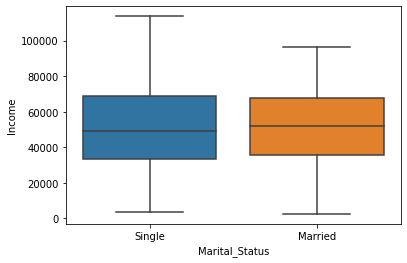

In [19]:
sns.boxplot(data=df_marketing_EDA_01[df_marketing_EDA_01["Marital_Status"].isin(["Married", "Single"])], 
            x="Marital_Status", y="Income", showfliers=False)

In [20]:
hypothesis_test(df_marketing_EDA_01[df_marketing_EDA_01["Marital_Status"]=="Single"]["Income"].dropna(axis=0),
                df_marketing_EDA_01[df_marketing_EDA_01["Marital_Status"]=="Married"]["Income"].dropna(axis=0))

Teste de Shapiro-Wilk: valor-p do grupo A: 0.000, valor-p do Grupo B: 0.000.
O Teste de Shapiro-Wilk demonstrou que, no mínimo, algum dos dois grupos não tem distribuição normal dos dados.
Teste de Mann-Whitney-U: stats: 197603.500, valor-p: 0.528.
O teste Mann-Whitney-U não demonstrou diferença significativa das medianas dos dois grupos: p-valor de 0.528.


* O teste de hipótese não demonstrou diferença significativa entre os pessoas casadas e soleiras em relação à renda.

## Tipos de dados

In [21]:
df_marketing_EDA_01.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

* A maior parte do dataset é de variáveis numéricas discretas.
* Uma outra parte é de variáveis categóricas:
  * Education
  * Marital_Status
  * AcceptedCmp3
  * AcceptedCmp4
  * AcceptedCmp5
  * AcceptedCmp1
  * AcceptedCmp2
  * Complain
  * Response
* Dt_Customer é uma variável datetime64

# Pré-Processamento 01

In [22]:
df_marketing_preprocessing_01 = df_marketing_EDA_01.copy()

## Transformar Dt_Customer em datetime64

In [23]:
df_marketing_preprocessing_01["Dt_Customer"] = df_marketing_preprocessing_01["Dt_Customer"].astype("datetime64")

# EDA 02

In [24]:
df_marketing_EDA_02 = df_marketing_preprocessing_01

In [25]:
cat_features = ["Education",
                "Marital_Status",
                "AcceptedCmp3",
                "AcceptedCmp4",
                "AcceptedCmp5",
                "AcceptedCmp1",
                "AcceptedCmp2",
                "Complain",
                "Response"]

In [26]:
num_features = df_marketing_EDA_02.drop(cat_features, axis=1).columns
num_features = num_features.drop(["Dt_Customer", "ID", "Z_CostContact", "Z_Revenue"]).tolist()

In [27]:
num_features

['Year_Birth',
 'Income',
 'Kidhome',
 'Teenhome',
 'Recency',
 'MntWines',
 'MntFruits',
 'MntMeatProducts',
 'MntFishProducts',
 'MntSweetProducts',
 'MntGoldProds',
 'NumDealsPurchases',
 'NumWebPurchases',
 'NumCatalogPurchases',
 'NumStorePurchases',
 'NumWebVisitsMonth']

## Correlação por múltiplos métodos

* Apliquei a função **associations()** para plotar correlações com múltiplos métodos:
 * Pearson para variáveis numéricas.
 * Cramer para variáveis categóricas.
 * Correlation ratio para variáveis numéricas e categóricas.

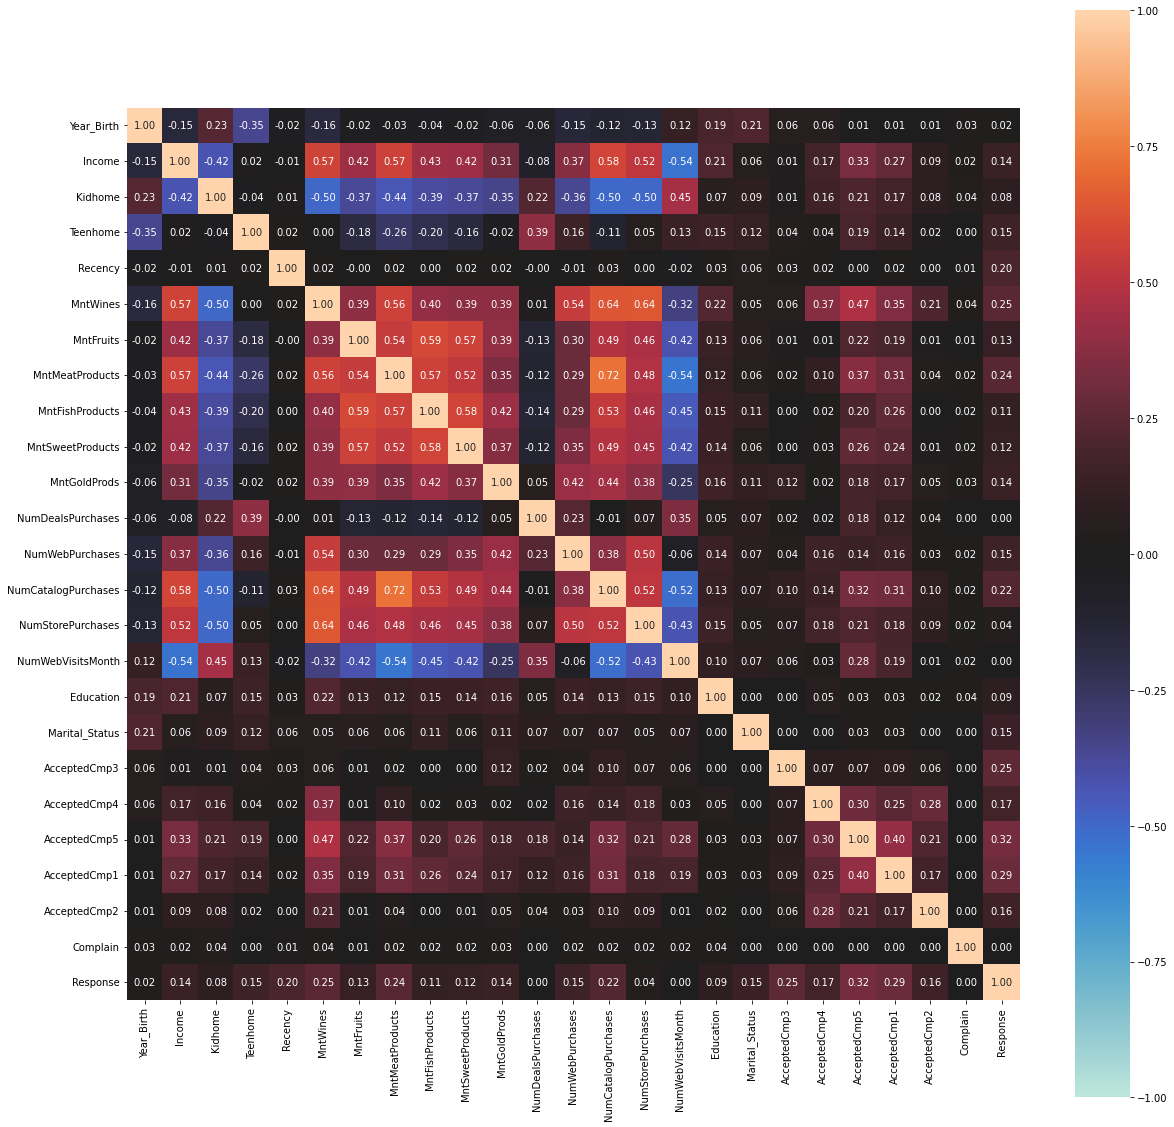

In [28]:
corr_df_marketing_EDA_02 = associations(df_marketing_EDA_02[num_features+cat_features], nominal_columns=cat_features, 
             numerical_columns=num_features, figsize=(20,20))

* Top 11 correlações mais fortes com a variável **Response**:
  * AcceptedCmp5: 0.32
  * AcceptedCmp1: 0.29
  * AcceptedCmp3: 0.25
  * MntWines: 0.25
  * MntMeatProducts: 0.24
  * NumCatalogPurchases: 0.22
  * Recency: 0.20
  * AcceptedCmp4: 0.17
  * AcceptedCmp2: 0.16
  * Teenhome: 0.15
  * NumWebPurchases: 0.15

* Correlações relativamente mais fortes entre as variáveis:
  * AcceptedCmp5:
    * MntWines: 0.47
    * AcceptedCmp1: 0.40
  * MntWines:
    * NumCatalogPurchases: 0.64
    * NumStorePurchases: 0.64
    * Kidhome: -0.50
  * MntMeatProducts:
    * NumCatalogPurchases: 0.72
    * NumWebVisitsMonth: -0.54
  * NumCatalogPurchases:
    * MntMeatProducts: 0.72
    *  NumWebVisitsMonth: -0.52
  * AcceptedCmp4: 
    * MntWines: 0.37
  * AcceptedCmp2:
    * AcceptedCmp4: 0.28
  * Teenhome: 
    * NumDealsPurchases: 0.39
    * YearBirth: -0.35
  * NumWebPurchases: 
    * MntWines: 0.54
    * Kidhome: -0.36

## AcceptedCmp5

###AcceptedCmp5 X Response

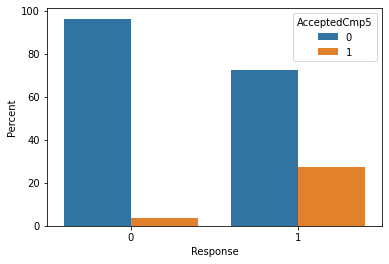

In [29]:
sns.barplot(hue="AcceptedCmp5", 
                x="Response", 
                y="Percent",
                data=df_marketing_EDA_02\
                .groupby("Response")["AcceptedCmp5"]\
                .value_counts(normalize=True)\
                .mul(100).rename("Percent")\
                .reset_index())

In [30]:
df_marketing_EDA_02\
                .groupby("Response")["AcceptedCmp5"]\
                .value_counts(normalize=True)\
                .mul(100).rename("Percent")\
                .reset_index()

,Response,AcceptedCmp5,Percent
0,0,0,96.274921
1,0,1,3.725079
2,1,0,72.455090
3,1,1,27.544910


* Pelo gráfico, praticamente **27.5%** do grupo que aceitou a oferta na última campanha está relacionado a aceitar a oferta na quinta campanha.
* Qual é o impacto de aceitar da quinta campanha em relação à variável Response?

In [31]:
results = smf.logit("Response ~ AcceptedCmp5", data=df_marketing_EDA_02).fit()
print(results.summary())

Optimization terminated successfully.
         Current function value: 0.383564
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:               Response   No. Observations:                 2240
Model:                          Logit   Df Residuals:                     2238
Method:                           MLE   Df Model:                            1
Date:                Mon, 23 May 2022   Pseudo R-squ.:                 0.08926
Time:                        13:38:10   Log-Likelihood:                -859.18
converged:                       True   LL-Null:                       -943.39
Covariance Type:            nonrobust   LLR p-value:                 1.641e-38
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -2.0259      0.068    -29.622      0.000      -2.160      -1.892
AcceptedCmp5     2.2850

* Interpretação dos coeficientes

In [32]:
intercepto_odds_ratio = np.exp(results.params[0])
AcceptedCmp5_odds_ratio = np.exp(results.params[1])
print(f"intercepto_odds_ratio: %.3f, AcceptedCmp5_odds_ratio: %.3f" % (intercepto_odds_ratio, AcceptedCmp5_odds_ratio))

intercepto_odds_ratio: 0.132, AcceptedCmp5_odds_ratio: 9.825



Para interpretar o intercepto, é necessário fazer uma segunda transformação.

In [33]:
print(((intercepto_odds_ratio/(1+intercepto_odds_ratio))*100).round(2), "%")

11.65 %


* Quando o cliente aceita a oferta na quinta campanha, há um aumento de **882.54%** na probabilidade do cliente aceitar a oferta na última campanha.

In [34]:
print(((AcceptedCmp5_odds_ratio-1)*100).round(2), "%")

882.54 %


#### Pressuposto 1: tipo de resultado binário.

In [35]:
df_marketing_EDA_02["Response"].nunique()

2

#### Pressuposto 2: Independência das amostras

In [36]:
results = smf.logit("Response ~ AcceptedCmp5", data=df_marketing_EDA_02).fit()
print(results.summary())

Optimization terminated successfully.
         Current function value: 0.383564
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:               Response   No. Observations:                 2240
Model:                          Logit   Df Residuals:                     2238
Method:                           MLE   Df Model:                            1
Date:                Mon, 23 May 2022   Pseudo R-squ.:                 0.08926
Time:                        13:38:10   Log-Likelihood:                -859.18
converged:                       True   LL-Null:                       -943.39
Covariance Type:            nonrobust   LLR p-value:                 1.641e-38
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -2.0259      0.068    -29.622      0.000      -2.160      -1.892
AcceptedCmp5     2.2850

In [37]:
durbin_watson(results.resid_generalized)

2.0480543942991987

* De acordo com o teste de Durbin-Watson, as amostras são independentes entre si, porque o resultado está próximo de 2.

#### Pressuposto 3: ausência de multicolinearidade
* Não é necessário calcular o VIF porque é um modelo de regressão logística de apenas uma variável independente.

#### Pressuposto 4: Linearidade das variáveis numéricas contínuas independentes e log-odds
* Não é necessário porque não há variáveis numéricas contínuas no modelo.


#### Pressuposto 5: tamanho da amostra
* Fórmula
  * N = 10 k / p
* k = o número de variáveis independentes
* p é a proporção de casos positivos (igual a 1)

In [38]:
# 1 variável independente
k = 1

# 0.149 é a proporção de casos positivos
p = list(df_marketing_EDA_02["Response"].value_counts()/df_marketing_EDA_02["Response"].value_counts().sum())[1]

# Fórmula do tamanho mínimo da amostra
N = (10*k)/p

# Se for abaixo de 100, é uma boa prática somar 100 na amostra mínima.
print("Amostra mínima:", round(N+100, 2))

Amostra mínima: 167.07


* O tamanho da amostra é superior ao mínimo da amostra.

#### Pressuposto 6: Poucos outliers

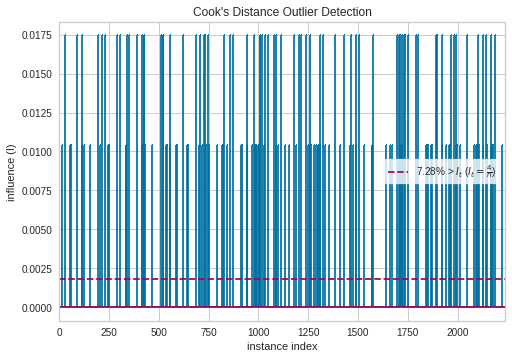

In [39]:
from yellowbrick.regressor import CooksDistance
viz_cook_distance = CooksDistance(draw_threshold=True)
viz_cook_distance.fit(df_marketing_EDA_02[["AcceptedCmp5"]], df_marketing_EDA_02["Response"])
viz_cook_distance.show()

* A distância de cook está bem abaixo de 1, que seria um ponto influente, tendo a distância máxima de 0.0175.
* Relativamente ao threshold, há muitos pontos influentes no modelo.

#### Conclusão
* Não foi possível estabelecer causalidade em aceitar a quinta campanha impacta positivamente na variável Response.

###AcceptedCmp5 X MntWines
* **Hipótese nula**: O grupo que aceitou a oferta na quinta campanha e o grupo que não aceitou têm gastos de vinho iguais.

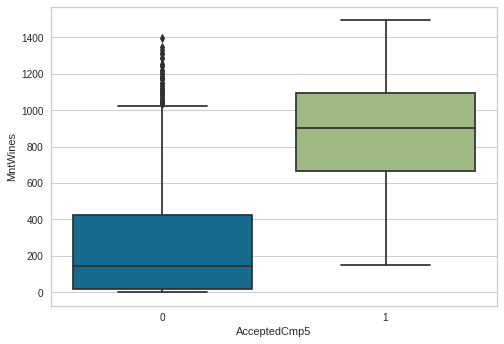

In [40]:
sns.boxplot(x="AcceptedCmp5", y="MntWines", data=df_marketing_EDA_02)

In [41]:
hypothesis_test(df_marketing_EDA_02[df_marketing_EDA_02["AcceptedCmp5"]==0]["MntWines"],
                df_marketing_EDA_02[df_marketing_EDA_02["AcceptedCmp5"]==1]["MntWines"])

Teste de Shapiro-Wilk: valor-p do grupo A: 0.000, valor-p do Grupo B: 0.021.
O Teste de Shapiro-Wilk demonstrou que, no mínimo, algum dos dois grupos não tem distribuição normal dos dados.
Teste de Mann-Whitney-U: stats: 31663.500, valor-p: 0.000.
O teste Mann-Whitney-U demonstrou diferença significativa das medianas dos dois grupos: p-valor de 0.000.


* O teste de shapiro-wilk demonstrou que os dois grupos não têm distribuição normal dos dados.
* O teste de Mann-Whitney-U demonstrou diferença significativa das medianas dos dois grupos desde que p-valor<=0.05.
* **Hipótese nula rejeitada:** o grupo que aceitou a oferta na quinta campanha e o grupo que não aceitou têm gastos de vinho iguais.
* **Hipótese alternativa:** o grupo que aceitou a oferta na quinta campanha e o grupo que não aceitou têm gastos de vinho diferentes.
* O grupo que aceitou a oferta tem quase 5 vezes mais gastos de vinhos nos últimos 2 anos na mediana do que o grupo que não aceitou a oferta na quinta campanha.

###AcceptedCmp5 X AcceptedCmp1

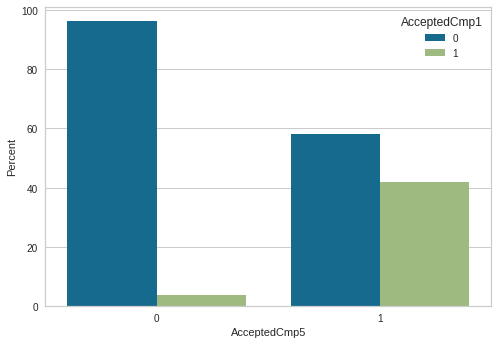

In [42]:
sns.barplot(x="AcceptedCmp5",
            y="Percent", 
            hue="AcceptedCmp1",
            data=df_marketing_EDA_02\
            .groupby("AcceptedCmp5")["AcceptedCmp1"]\
            .value_counts(normalize=True)\
            .mul(100).rename("Percent")\
            .reset_index())


* Praticamente 40% dos clientes que aceitaram a oferta na quinta campanha, aceitaram também a oferta na primeira campanha.

In [43]:
results = smf.logit("AcceptedCmp5 ~ AcceptedCmp1", data=df_marketing_EDA_02).fit()
print(results.summary())

Optimization terminated successfully.
         Current function value: 0.217110
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:           AcceptedCmp5   No. Observations:                 2240
Model:                          Logit   Df Residuals:                     2238
Method:                           MLE   Df Model:                            1
Date:                Mon, 23 May 2022   Pseudo R-squ.:                  0.1673
Time:                        13:38:11   Log-Likelihood:                -486.33
converged:                       True   LL-Null:                       -584.06
Covariance Type:            nonrobust   LLR p-value:                 2.040e-44
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -3.0475      0.105    -29.023      0.000      -3.253      -2.842
AcceptedCmp1     2.9363

* Interpretação dos coeficientes

In [44]:
intercepto_odds_ratio = np.exp(results.params[0])
AcceptedCmp1_odds_ratio = np.exp(results.params[1])
print(f"intercepto_odds_ratio: %.3f, AcceptedCmp5_odds_ratio: %.3f" % (intercepto_odds_ratio, AcceptedCmp1_odds_ratio))

intercepto_odds_ratio: 0.047, AcceptedCmp5_odds_ratio: 18.846



Para interpretar o intercepto, é necessário fazer uma segunda transformação.

In [45]:
print(((intercepto_odds_ratio/(1+intercepto_odds_ratio))*100).round(2), "%")

4.53 %


In [46]:
print(((AcceptedCmp1_odds_ratio-1)*100).round(2), "%")

1784.6 %


* Quando o cliente aceita a oferta na primeira campanha, há um aumento de **1784.6%** na probabilidade do cliente aceitar a oferta na quinta campanha.

#### Pressuposto 1: tipo de resultado binário.

In [47]:
df_marketing_EDA_02["AcceptedCmp5"].nunique()

2

#### Pressuposto 2: Independência das amostras

In [48]:
results = smf.logit("AcceptedCmp5 ~ AcceptedCmp1", data=df_marketing_EDA_02).fit()
print(results.summary())

Optimization terminated successfully.
         Current function value: 0.217110
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:           AcceptedCmp5   No. Observations:                 2240
Model:                          Logit   Df Residuals:                     2238
Method:                           MLE   Df Model:                            1
Date:                Mon, 23 May 2022   Pseudo R-squ.:                  0.1673
Time:                        13:38:11   Log-Likelihood:                -486.33
converged:                       True   LL-Null:                       -584.06
Covariance Type:            nonrobust   LLR p-value:                 2.040e-44
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -3.0475      0.105    -29.023      0.000      -3.253      -2.842
AcceptedCmp1     2.9363

In [49]:
durbin_watson(results.resid_generalized)

2.0058124341462045

* De acordo com o teste de Durbin-Watson, as amostras são independentes entre si, porque o resultado está próximo de 2.

#### Pressuposto 3: ausência de multicolinearidade
* Não é necessário calcular o VIF porque é um modelo de regressão logística de apenas uma variável independente.

#### Pressuposto 4: Linearidade das variáveis numéricas contínuas independentes e log-odds
* Não é necessário porque não há variáveis numéricas contínuas no modelo.


#### Pressuposto 5: tamanho da amostra
* Fórmula
  * N = 10 k / p
* k = o número de variáveis independentes
* p é a proporção de casos positivos (igual a 1)

In [50]:
# 1 variável independente
k = 1

# 0.149 é a proporção de casos positivos
p = list(df_marketing_EDA_02["AcceptedCmp5"].value_counts()/df_marketing_EDA_02["AcceptedCmp5"].value_counts().sum())[1]

# Fórmula do tamanho mínimo da amostra
N = (10*k)/p

# Se for abaixo de 100, é uma boa prática somar 100 na amostra mínima.
print("Amostra mínima:", round(N, 2))

Amostra mínima: 137.42


* O tamanho da amostra é superior ao mínimo da amostra.

#### Pressuposto 6: Poucos outliers

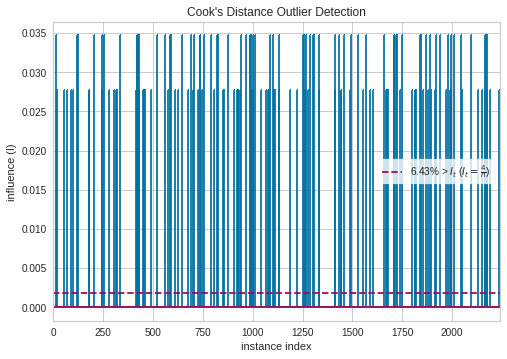

In [51]:
from yellowbrick.regressor import CooksDistance
viz_cook_distance = CooksDistance(draw_threshold=True)
viz_cook_distance.fit(df_marketing_EDA_02[["AcceptedCmp1"]], df_marketing_EDA_02["AcceptedCmp5"])
viz_cook_distance.show()

* A distância de cook está bem abaixo de 1, que seria um ponto influente, tendo a distância máxima de 0.035.
* Relativamente ao threshold, há muitos pontos influentes.

#### Conclusão
* Não foi possível estabelecer causalidade em aceitar a primeira campanha impacta positivamente a quinta campanha.

## Todos os AcceptedCmp - de 1 a 5 X Response

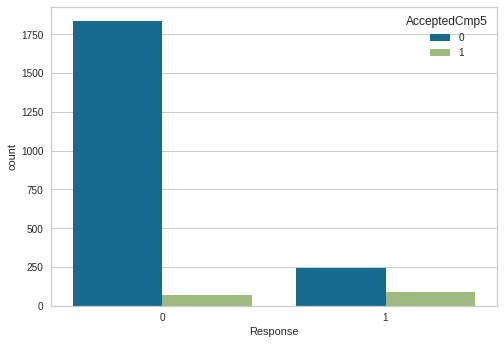

In [52]:
sns.countplot(hue="AcceptedCmp5", x="Response", data=df_marketing_EDA_02)

* Metade dos clientes que aceitaram a oferta estão associados à quinta campanha.
* Qual é o impacto de aceitar da primeira até a quinta campanha em relação à variável Response?

In [53]:
from statsmodels.genmod.generalized_linear_model import GLM
from statsmodels.genmod import families

results = smf.logit("Response~AcceptedCmp5 + AcceptedCmp4 + AcceptedCmp3 + AcceptedCmp2 + AcceptedCmp1",
              df_marketing_EDA_02).fit()
print(results.summary())

Optimization terminated successfully.
         Current function value: 0.348546
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:               Response   No. Observations:                 2240
Model:                          Logit   Df Residuals:                     2234
Method:                           MLE   Df Model:                            5
Date:                Mon, 23 May 2022   Pseudo R-squ.:                  0.1724
Time:                        13:38:12   Log-Likelihood:                -780.74
converged:                       True   LL-Null:                       -943.39
Covariance Type:            nonrobust   LLR p-value:                 3.631e-68
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -2.3850      0.082    -29.056      0.000      -2.546      -2.224
AcceptedCmp5     1.5939

* Todas as variáveis são importantes, desde que o valor-p<=0.05 para prever a variável Response.

* Interpretação dos coeficientes

In [54]:
intercepto_odds_ratio = np.exp(results.params[0])
AcceptedCmp5_odds_ratio = np.exp(results.params[1])
AcceptedCmp4_odds_ratio = np.exp(results.params[2])
AcceptedCmp3_odds_ratio = np.exp(results.params[3])
AcceptedCmp2_odds_ratio = np.exp(results.params[4])
AcceptedCmp1_odds_ratio = np.exp(results.params[5])

print(f"""intercepto_odds_ratio: %.3f, 
AcceptedCmp5_odds_ratio: %.3f, 
AcceptedCmp4_odds_ratio: %.3f,
AcceptedCmp3_odds_ratio: %.3f,
AcceptedCmp2_odds_ratio: %.3f,
AcceptedCmp1_odds_ratio: %.3f""" % (intercepto_odds_ratio, 
                                    AcceptedCmp5_odds_ratio,
                                    AcceptedCmp4_odds_ratio,
                                    AcceptedCmp3_odds_ratio,
                                    AcceptedCmp2_odds_ratio,
                                    AcceptedCmp1_odds_ratio))

intercepto_odds_ratio: 0.092, 
AcceptedCmp5_odds_ratio: 4.923, 
AcceptedCmp4_odds_ratio: 2.011,
AcceptedCmp3_odds_ratio: 6.665,
AcceptedCmp2_odds_ratio: 2.606,
AcceptedCmp1_odds_ratio: 3.749


In [55]:
all_odds_ratio = [AcceptedCmp1_odds_ratio, AcceptedCmp2_odds_ratio, 
                  AcceptedCmp3_odds_ratio, AcceptedCmp4_odds_ratio,
                  AcceptedCmp5_odds_ratio]

for i in range(len(all_odds_ratio)):      
  print("AcceptedCmp_"+str(i+1)+"_odds_ratio", " ", ((all_odds_ratio[i]-1)*100).round(2), "%")

AcceptedCmp_1_odds_ratio   274.9 %
AcceptedCmp_2_odds_ratio   160.6 %
AcceptedCmp_3_odds_ratio   566.53 %
AcceptedCmp_4_odds_ratio   101.1 %
AcceptedCmp_5_odds_ratio   392.28 %


* Quando o cliente aceita a oferta na primeira campanha, há um aumento de **274.9%** na probabilidade do cliente aceitar a oferta na última campanha, mantendo as outras variáveis fixas.
* Quando o cliente aceita a oferta na segunda campanha, há um aumento de **160.6%** na probabilidade do cliente aceitar a oferta na última campanha, mantendo as outras variáveis fixas.
* Quando o cliente aceita a oferta na terceira campanha, há um aumento de **566.53%** na probabilidade do cliente aceitar a oferta na última campanha, mantendo as outras variáveis fixas.
* Quando o cliente aceita a oferta na quarta campanha, há um aumento de **101.1%** na probabilidade do cliente aceitar a oferta na última campanha, mantendo as outras variáveis fixas.
* Quando o cliente aceita a oferta na quarta campanha, há um aumento de **392.28%** na probabilidade do cliente aceitar a oferta na última campanha, mantendo as outras variáveis fixas.

#### Pressuposto 1: tipo de resultado binário.

In [56]:
df_marketing_EDA_02["Response"].nunique()

2

#### Pressuposto 2: Independência das amostras

In [57]:
durbin_watson(results.resid_generalized)

2.0177337927711783

* De acordo com o teste de Durbin-Watson, as amostras são independentes entre si, porque o resultado está próximo de 2.

#### Pressuposto 3: ausência de multicolinearidade

In [58]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# variáveis independentes do dataset df_marketing_EDA_02
X = df_marketing_EDA_02[['AcceptedCmp5', 'AcceptedCmp4', 'AcceptedCmp3', 'AcceptedCmp2', 'AcceptedCmp1']]
  
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
  
print(vif_data)

        feature       VIF
0  AcceptedCmp5  1.366860
1  AcceptedCmp4  1.261049
2  AcceptedCmp3  1.045406
3  AcceptedCmp2  1.143379
4  AcceptedCmp1  1.304541


* VIF abaixo de 5 indica ausência ou fraca correlação entre as variáveis

#### Pressuposto 4: Linearidade das variáveis numéricas contínuas independentes e log-odds
* Não é necessário porque não há variáveis numéricas contínuas no modelo.


#### Pressuposto 5: tamanho da amostra
* Fórmula
  * N = 10 k / p
* k = o número de variáveis independentes
* p é a proporção de casos positivos (igual a 1)

In [59]:
# 5 variável independente
k = 5

# 0.149 é a proporção de casos positivos
p = list(df_marketing_EDA_02["Response"].value_counts()/df_marketing_EDA_02["Response"].value_counts().sum())[1]

# Fórmula do tamanho mínimo da amostra
N = (10*k)/p

# Se for abaixo de 100, é uma boa prática somar 100 na amostra mínima.
print("Amostra mínima:", round(N, 2))

Amostra mínima: 335.33


* O tamanho da amostra é superior ao mínimo da amostra.

### Pressuposto 6: Poucos outliers

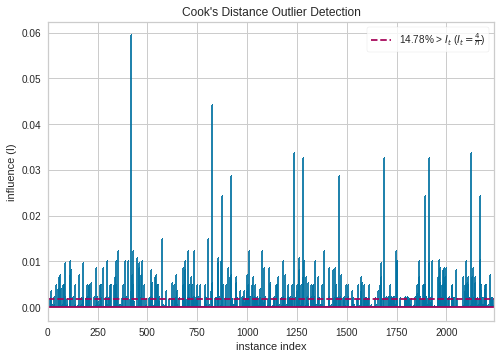

In [60]:
from yellowbrick.regressor import CooksDistance
viz_cook_distance = CooksDistance(draw_threshold=True)
viz_cook_distance.fit(X, df_marketing_EDA_02["Response"])
viz_cook_distance.show()

* A distância de cook está bem abaixo de 1, que seria um ponto influente, tendo a distância máxima de 0.06.
* Porém, relativamente ao threshold, há muitos pontos influentes.

### Conclusão
* Não foi possível concluir causalidade entre aceitar a oferta nas campanhas 1, 2, 3, 4 e 5, e a variável Response.

## AcceptedCmp1

### AcceptedCmp1 X Response

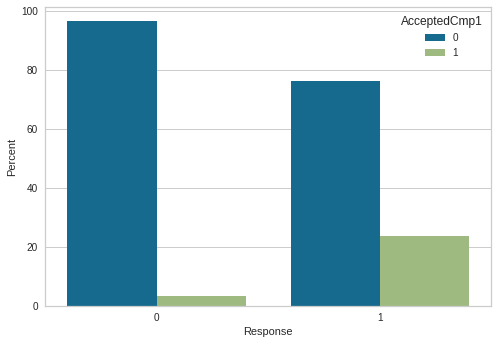

In [61]:
sns.barplot(x="Response",
            y="Percent", 
            hue="AcceptedCmp1",
            data=df_marketing_EDA_02\
            .groupby("Response")["AcceptedCmp1"]\
            .value_counts(normalize=True)\
            .mul(100).rename("Percent")\
            .reset_index())

In [62]:
df_marketing_EDA_02.groupby("Response")["AcceptedCmp1"]\
            .value_counts(normalize=True)\
            .mul(100).rename("Percent")\
            .reset_index()

,Response,AcceptedCmp1,Percent
0,0,0,96.589717
1,0,1,3.410283
2,1,0,76.347305
3,1,1,23.652695


* Praticamente **23%** do grupo que aceitou a oferta na última campanha aceitou também oferta na primeira campanha.

## AcceptedCmp3

### AcceptedCmp3 X Response

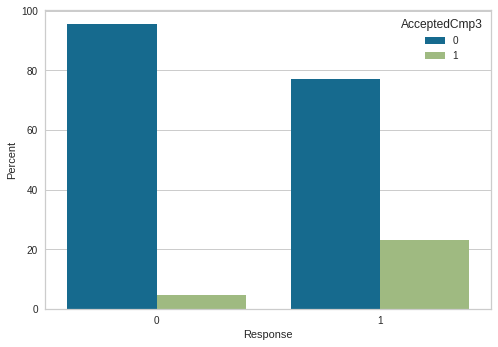

In [63]:
sns.barplot(x="Response",
            y="Percent", 
            hue="AcceptedCmp3",
            data=df_marketing_EDA_02\
            .groupby("Response")["AcceptedCmp3"]\
            .value_counts(normalize=True)\
            .mul(100).rename("Percent")\
            .reset_index())

In [64]:
df_marketing_EDA_02\
            .groupby("Response")["AcceptedCmp3"]\
            .value_counts(normalize=True)\
            .mul(100).rename("Percent")\
            .reset_index()

,Response,AcceptedCmp3,Percent
0,0,0,95.487933
1,0,1,4.512067
2,1,0,76.946108
3,1,1,23.053892


* Praticamente **23%** do grupo que aceitou a oferta na última campanha aceitou também oferta na terceira campanha.

## MntWines

### MntWines X Response

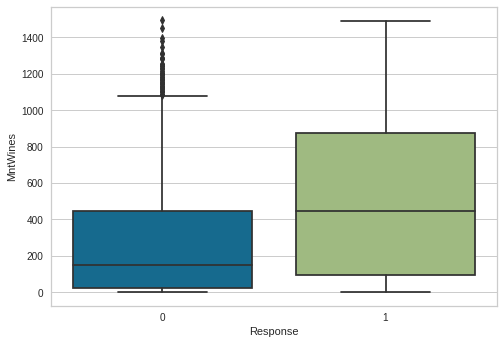

In [65]:
sns.boxplot(y="MntWines", x="Response", data=df_marketing_EDA_02)

* Visualmente no boxplot os clientes que aceitaram a oferta na última campanha gastaram mais em vinho nos últimos dois anos do que os clientes que não aceitaram a oferta na última campanha. 
* Essa diferença tem significância estatística?

In [66]:
  hypothesis_test(df_marketing_EDA_02[df_marketing_EDA_02["Response"]==0]["MntWines"],
                  df_marketing_EDA_02[df_marketing_EDA_02["Response"]==1]["MntWines"])

Teste de Shapiro-Wilk: valor-p do grupo A: 0.000, valor-p do Grupo B: 0.000.
O Teste de Shapiro-Wilk demonstrou que, no mínimo, algum dos dois grupos não tem distribuição normal dos dados.
Teste de Mann-Whitney-U: stats: 215610.000, valor-p: 0.000.
O teste Mann-Whitney-U demonstrou diferença significativa das medianas dos dois grupos: p-valor de 0.000.


* O teste de Mann-Whitney-U demonstrou que a mediana dos dois grupos tem uma diferença significativa, desde que valor-p<=0.05.
* Podemos considerar os aceitadores da oferta da última campanha são ótimos apreciadores de vinho.

### Mntwines X NumCatalogPurchases

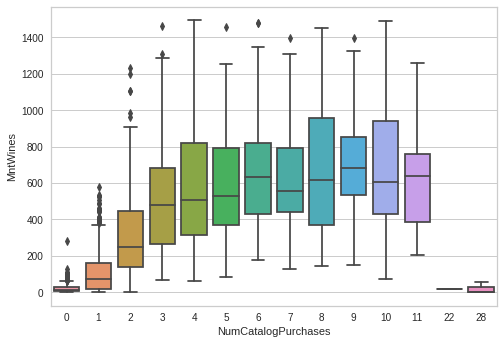

In [67]:
sns.boxplot(x="NumCatalogPurchases", y="MntWines", data=df_marketing_EDA_02)

* Pelo gráfico, há muitos grupos de compra, é melhor reduzir os grupos a partir de uma nova categoria.

In [68]:
cat_num_catalog_purchase = [-1, 6, 100]
df_marketing_EDA_02["Cat_num_catalog_purchases"] = pd.cut(df_marketing_EDA_02["NumCatalogPurchases"],
       bins=cat_num_catalog_purchase,
       labels=["Low_purchase", "High_purchase"])

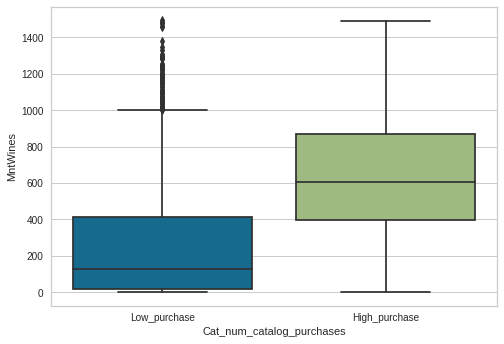

In [69]:
sns.boxplot(x="Cat_num_catalog_purchases", y="MntWines", data=df_marketing_EDA_02)

* O agrupamento está melhor para fazer a análise.
* **Hipótese nula**: as medianas dos dois grupos de alto e baixo consumo são iguais.

In [70]:
hypothesis_test(df_marketing_EDA_02[df_marketing_EDA_02["Cat_num_catalog_purchases"]=="Low_purchase"]["MntWines"], 
                df_marketing_EDA_02[df_marketing_EDA_02["Cat_num_catalog_purchases"]=="High_purchase"]["MntWines"])

Teste de Shapiro-Wilk: valor-p do grupo A: 0.000, valor-p do Grupo B: 0.002.
O Teste de Shapiro-Wilk demonstrou que, no mínimo, algum dos dois grupos não tem distribuição normal dos dados.
Teste de Mann-Whitney-U: stats: 89247.500, valor-p: 0.000.
O teste Mann-Whitney-U demonstrou diferença significativa das medianas dos dois grupos: p-valor de 0.000.


* Pelo teste de Mann-Whitney-U, a **hipótese nula foi rejeitada**.
* Logo, **a hipótese alternativa** foi aceita: as medianas dos dois grupos de alto e baixo consumo são diferentes.
* O grupo de alto consumo por catálogo pagou mais vinho na mediana nos últimos dois anos do que o grupo de baixo consumo.

### Mntwines X Kidhome

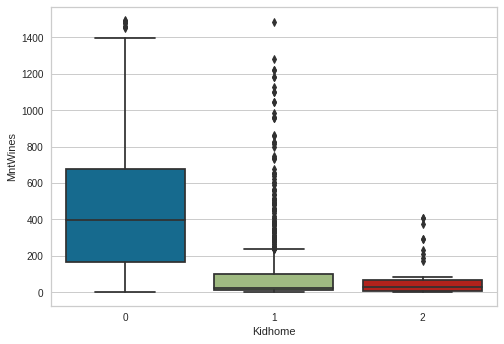

In [71]:
sns.boxplot(x="Kidhome", y="MntWines", data=df_marketing_EDA_02)

* Pelo boxplot, não ter criança e ter alguma criança está associado aos gastos de vinho. Vou agrupar o número de crianças em uma variável boleana para facilitar a análise.

In [72]:
cat_kidhome = [-1, 0, 3]

df_marketing_EDA_02["cat_kidhome"] = pd.cut(df_marketing_EDA_02["Kidhome"],
                                        bins=cat_kidhome,
                                        labels=[False, True])

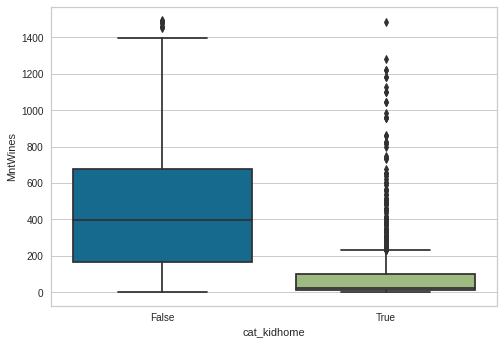

In [73]:
sns.boxplot(data=df_marketing_EDA_02, x="cat_kidhome", y="MntWines")

* Há muitos outliers nesse boxplot.
* Para isso, é melhor fazer um teste de hipótese baseado em mediana.
* **Hipótese nula**: o grupo sem criança e com criança têm gastos, na mediana, iguais de vinho nos últimos dois anos.

In [74]:
hypothesis_test(df_marketing_EDA_02[df_marketing_EDA_02["cat_kidhome"]==False]["MntWines"],
                df_marketing_EDA_02[df_marketing_EDA_02["cat_kidhome"]==True]["MntWines"])

Teste de Shapiro-Wilk: valor-p do grupo A: 0.000, valor-p do Grupo B: 0.000.
O Teste de Shapiro-Wilk demonstrou que, no mínimo, algum dos dois grupos não tem distribuição normal dos dados.
Teste de Mann-Whitney-U: stats: 1029851.000, valor-p: 0.000.
O teste Mann-Whitney-U demonstrou diferença significativa das medianas dos dois grupos: p-valor de 0.000.


* **Hipótese nula rejeitada** de acordo com o teste de Mann-Whitney-U, desde que valor-p<=0.05.
* Escolha da **Hipótese alternativa**: o grupo sem criança e com criança têm gastos, na mediana, diferentes de vinho nos últimos dois anos.
* O grupo que não tem criança em casa compra mais vinho na mediana do que o grupo com crianças em casa.

## MntMeatProducts:


### MntMeatProducts X Response


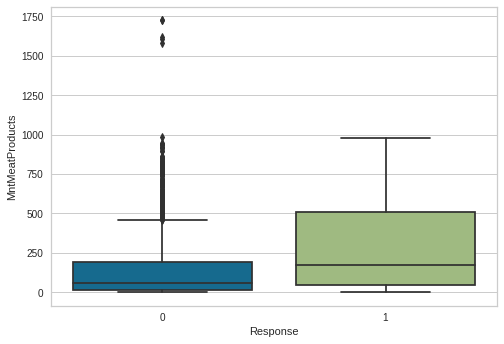

In [75]:
sns.boxplot(x="Response", y="MntMeatProducts", data=df_marketing_EDA_02)

* Há muitos outliers no grupo que não aceitou a oferta na última campanha.
* O grupo que aceitou a oferta na última campanha gastou mais em carne nos últimos 2 anos do que o grupo que não aceitou a oferta na última campanha. Essa diferença é significativa?
* **Hipótese nula**: O grupo que aceitou a oferta na última campanha gastou, na mediana, igualmente em carne nos últimos 2 anos do que o grupo que não aceitou a oferta na última campanha.

In [76]:
hypothesis_test(df_marketing_EDA_02[df_marketing_EDA_02["Response"]==0]["MntMeatProducts"],
                df_marketing_EDA_02[df_marketing_EDA_02["Response"]==1]["MntMeatProducts"])

Teste de Shapiro-Wilk: valor-p do grupo A: 0.000, valor-p do Grupo B: 0.000.
O Teste de Shapiro-Wilk demonstrou que, no mínimo, algum dos dois grupos não tem distribuição normal dos dados.
Teste de Mann-Whitney-U: stats: 203156.000, valor-p: 0.000.
O teste Mann-Whitney-U demonstrou diferença significativa das medianas dos dois grupos: p-valor de 0.000.


* De acordo com o teste de Mann-Whitney-U, a **hipótese nula foi rejeitada**, desde que o valor-p<=0.05.
* Escolhi a **hipótese alternativa**: O grupo que aceitou a oferta na última campanha gastou, na mediana, diferentemente em carne nos últimos 2 anos do que o grupo que não aceitou a oferta na última campanha.
* O grupo que aceitou a oferta na última campanha gastou mais em carne nos últimos 2 anos do que o grupo que não aceitou a oferta na última campanha.

### MntMeatProducts X NumCatalogPurchases


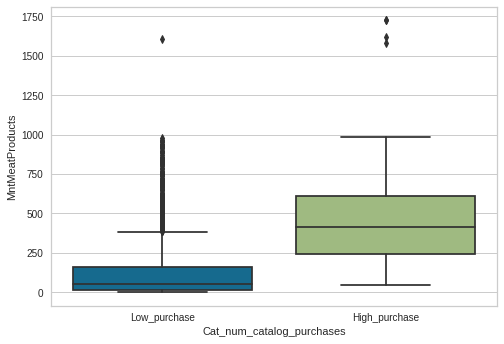

In [77]:
sns.boxplot(data=df_marketing_EDA_02, y="MntMeatProducts", x="Cat_num_catalog_purchases")

* Muitos outliers na categoria "Low_purchase".
* Pelo gráfico, grupo que compra muito pelo catálogo, na mediana, gasta mais em carne nos últimos dois anos em relação ao grupo que compra pouco pelo catálogo. Essa diferença é significantemente estatística?
* **Hipótese nula**: o grupo que compra muito pelo catálogo, na mediana, gasta igual em carne nos últimos dois anos em relação ao grupo que compra pouco pelo catálogo.

In [78]:
hypothesis_test(df_marketing_EDA_02[df_marketing_EDA_02["Cat_num_catalog_purchases"]=="Low_purchase"]["MntMeatProducts"],
                df_marketing_EDA_02[df_marketing_EDA_02["Cat_num_catalog_purchases"]=="High_purchase"]["MntMeatProducts"])

Teste de Shapiro-Wilk: valor-p do grupo A: 0.000, valor-p do Grupo B: 0.000.
O Teste de Shapiro-Wilk demonstrou que, no mínimo, algum dos dois grupos não tem distribuição normal dos dados.
Teste de Mann-Whitney-U: stats: 62229.000, valor-p: 0.000.
O teste Mann-Whitney-U demonstrou diferença significativa das medianas dos dois grupos: p-valor de 0.000.


* Pelo teste de Mann-Whitney-U, a **hipótese nula foi rejeitada**.
* Assim, escolhi a **hipótese alternativa**: o grupo que compra muito pelo catálogo, na mediana, gasta diferentemente em carne nos últimos dois anos em relação ao grupo que compra pouco pelo catálogo.

### MntMeatProducts X NumWebVisitsMonth


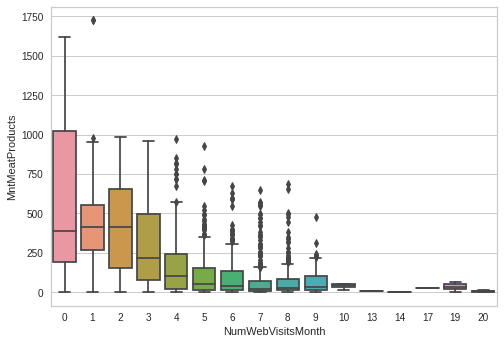

In [79]:
sns.boxplot(data=df_marketing_EDA_02, y="MntMeatProducts", x="NumWebVisitsMonth")

* Reduzir a quantidade de grupos pode ser benéfico para uma análise mais robusta.

In [80]:
cat_num_web_visits_month = [-1, 4, 25]

df_marketing_EDA_02["cat_num_web_visits_month"] = pd.cut(df_marketing_EDA_02["NumWebVisitsMonth"],
                                        bins=cat_num_web_visits_month,
                                        labels=["Low_visits", "High_visits"])

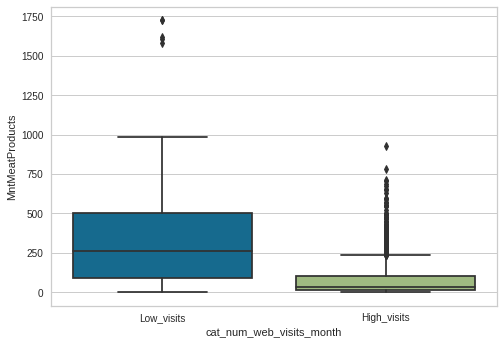

In [81]:
sns.boxplot(data=df_marketing_EDA_02, y="MntMeatProducts", x="cat_num_web_visits_month")

* Há muitos outliers na categoria "High_visits". É mais adequado usar a mediana.
* O grupo de baixas visitas por mês gastou mais em carne nos últimos dois anos em relação ao grupo de altas visitas por mês. Essa diferença tem significância estatística?
* **Hipótese nula**: o grupo de baixas visitas mensais pela web gastou igualmente em carne nos últimos dois anos em relação ao grupo de altas visitas mensais pela web. 

In [82]:
hypothesis_test(df_marketing_EDA_02[df_marketing_EDA_02["cat_num_web_visits_month"]=="Low_visits"]["MntMeatProducts"],
                df_marketing_EDA_02[df_marketing_EDA_02["cat_num_web_visits_month"]=="High_visits"]["MntMeatProducts"])

Teste de Shapiro-Wilk: valor-p do grupo A: 0.000, valor-p do Grupo B: 0.000.
O Teste de Shapiro-Wilk demonstrou que, no mínimo, algum dos dois grupos não tem distribuição normal dos dados.
Teste de Mann-Whitney-U: stats: 913027.000, valor-p: 0.000.
O teste Mann-Whitney-U demonstrou diferença significativa das medianas dos dois grupos: p-valor de 0.000.


* Pelo teste de Mann-Whitney-U, a **hipótese nula foi rejeitada**, desde que o valor-p<=0.05.
* Assim, escolhi a **hipótese alternativa**: o grupo de baixas visitas mensais pela web gastou diferentemente em carne nos últimos dois anos em relação ao grupo de altas visitas mensais pela web.

## NumCatalogPurchases

###NumCatalogPurchases X Response

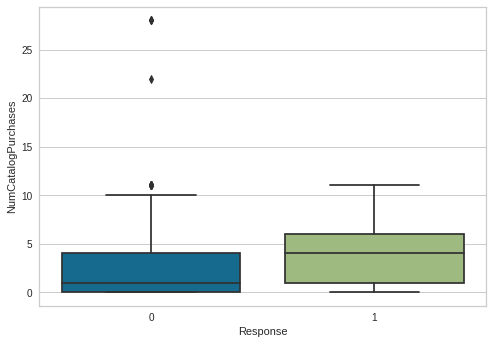

In [83]:
sns.boxplot(data=df_marketing_EDA_02, y="NumCatalogPurchases", x="Response")

* O grupo que aceitou a oferta na última campanha, na mediana, comprou pelo catálogo mais que o grupo que não aceitou a oferta na última campanha.
* Essa diferença é estatisticamente significativa?
* **Hipótese nula**: O grupo que aceitou a oferta na última campanha, na mediana, comprou pelo catálogo igual ao grupo que não aceitou a oferta na última campanha.

In [84]:
hypothesis_test(df_marketing_EDA_02[df_marketing_EDA_02["Response"]==0]["NumCatalogPurchases"],
                df_marketing_EDA_02[df_marketing_EDA_02["Response"]==1]["NumCatalogPurchases"])

Teste de Shapiro-Wilk: valor-p do grupo A: 0.000, valor-p do Grupo B: 0.000.
O Teste de Shapiro-Wilk demonstrou que, no mínimo, algum dos dois grupos não tem distribuição normal dos dados.
Teste de Mann-Whitney-U: stats: 199937.500, valor-p: 0.000.
O teste Mann-Whitney-U demonstrou diferença significativa das medianas dos dois grupos: p-valor de 0.000.


* De acordo com  o teste de Mann-Whitney-U, a **hipótese nula foi rejeitada**, desde que o valor-p<=0.05.
* Logo escolhi a **hipótese alternativa**: O grupo que aceitou a oferta na última campanha, na mediana, comprou pelo catálogo diferentemente em relação ao grupo que não aceitou a oferta na última campanha.
* O grupo que aceitou a oferta na última campanha comprou mais produtos pelo catálogo do que o grupo que não aceitou a oferta na última campanha.

###NumCatalogPurchases X NumWebVisitsMonth

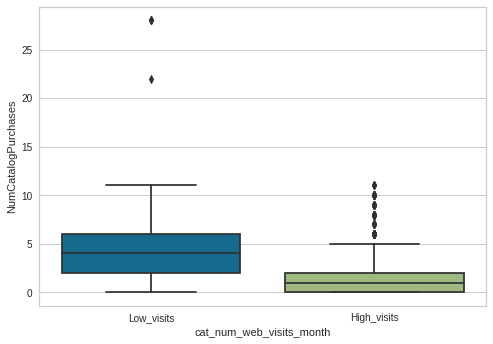

In [85]:
sns.boxplot(data=df_marketing_EDA_02, y="NumCatalogPurchases", x="cat_num_web_visits_month")

* Há poucos outliers no boxplot
* Muitas visitas mensais pela web estão relacionadas ao baixo consumo usando o catálogo.
* **Hipótese nula**: os dois grupos, o de baixas visitas e o de alta visitas, apresentam, na mediana, quantidade de compras pelo catálogo iguais.

In [86]:
hypothesis_test(df_marketing_EDA_02[df_marketing_EDA_02["cat_num_web_visits_month"]=="Low_visits"]["NumCatalogPurchases"],
                df_marketing_EDA_02[df_marketing_EDA_02["cat_num_web_visits_month"]=="High_visits"]["NumCatalogPurchases"])

Teste de Shapiro-Wilk: valor-p do grupo A: 0.000, valor-p do Grupo B: 0.000.
O Teste de Shapiro-Wilk demonstrou que, no mínimo, algum dos dois grupos não tem distribuição normal dos dados.
Teste de Mann-Whitney-U: stats: 912621.500, valor-p: 0.000.
O teste Mann-Whitney-U demonstrou diferença significativa das medianas dos dois grupos: p-valor de 0.000.


* De acordo com o teste de Mann-Whitney-U, a **hipótese nula foi rejeitada**, desde que o valor-p<=0.05.
* Logo, escolhi a **hipótese alternativa**: os dois grupos, o de baixas visitas e o de alta visitas, apresentam, na mediana, quantidade de compras pelo catálogo diferentes.
* O grupo de baixas visitas mensais pela web comprou mais através do catálogo em relação ao grupo de altas visitas mensais pela web.

## AcceptedCmp4

### AcceptedCmp4 X Response

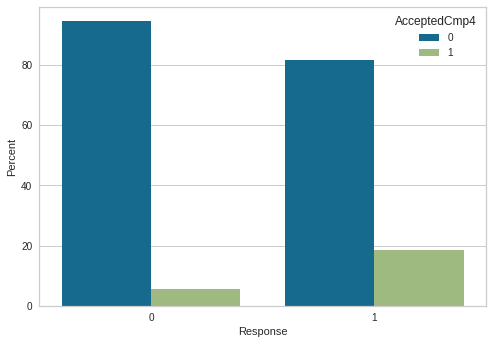

In [87]:
sns.barplot(x="Response",
            y="Percent", 
            hue="AcceptedCmp4",
            data=df_marketing_EDA_02\
            .groupby("Response")["AcceptedCmp4"]\
            .value_counts(normalize=True)\
            .mul(100).rename("Percent")\
            .reset_index())

In [88]:
df_marketing_EDA_02\
            .groupby("Response")["AcceptedCmp4"]\
            .value_counts(normalize=True)\
            .mul(100).rename("Percent")\
            .reset_index()

,Response,AcceptedCmp4,Percent
0,0,0,94.491081
1,0,1,5.508919
2,1,0,81.437126
3,1,1,18.562874


* Praticamente **18.5%** do grupo que aceitou a oferta na última campanha aceitou também oferta na quarta campanha.

### AcceptedCmp4 X MntWines

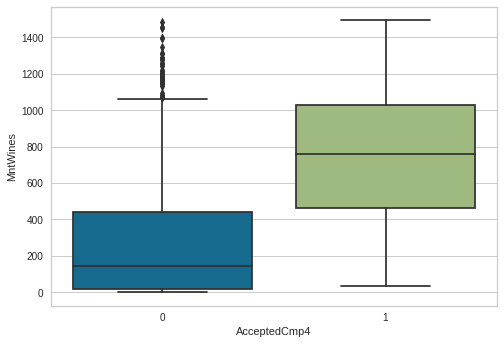

In [89]:
sns.boxplot(data=df_marketing_EDA_02, y="MntWines", x="AcceptedCmp4")

* De acordo com o boxplot, os clientes que aceitaram a oferta na quarta campanha consomem mais vinho que aqueles que não aceitaram na quarta campanha.
* Essa diferença tem significância estatística?
* **Hipótese nula**: Os clientes que aceitaram a oferta na quarta campanha consomem, na mediana, igualmente vinho em relação àqueles que não aceitaram na quarta campanha.

In [90]:
hypothesis_test(df_marketing_EDA_02[df_marketing_EDA_02["AcceptedCmp4"]==0]["MntWines"],
                df_marketing_EDA_02[df_marketing_EDA_02["AcceptedCmp4"]==1]["MntWines"])

Teste de Shapiro-Wilk: valor-p do grupo A: 0.000, valor-p do Grupo B: 0.002.
O Teste de Shapiro-Wilk demonstrou que, no mínimo, algum dos dois grupos não tem distribuição normal dos dados.
Teste de Mann-Whitney-U: stats: 54895.000, valor-p: 0.000.
O teste Mann-Whitney-U demonstrou diferença significativa das medianas dos dois grupos: p-valor de 0.000.


* De acordo com o Teste de Mann-Whitney-U, a **hipótese nula foi rejeitada**, desde que o valor-p<=0.05.
* Logo, escolhi a **hipótese alternativa**: Os clientes que aceitaram a oferta na quarta campanha consomem, na mediana, diferentemente vinho em relação àqueles que não aceitaram na quarta campanha.
* Os clientes que aceitaram a oferta na quarta campanha consomem mais vinho que aqueles que não aceitaram na quarta campanha.

##AcceptedCmp2

### AcceptedCmp2 X Response



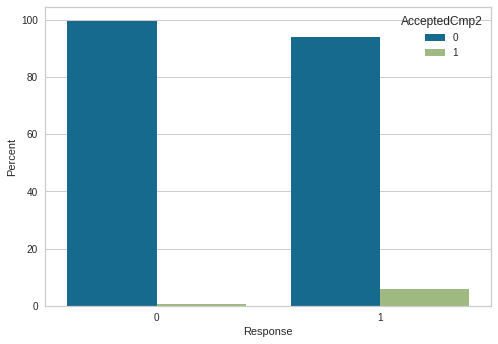

In [91]:
sns.barplot(x="Response",
            y="Percent", 
            hue="AcceptedCmp2",
            data=df_marketing_EDA_02\
            .groupby("Response")["AcceptedCmp2"]\
            .value_counts(normalize=True)\
            .mul(100).rename("Percent")\
            .reset_index())

In [92]:
df_marketing_EDA_02\
            .groupby("Response")["AcceptedCmp2"]\
            .value_counts(normalize=True)\
            .mul(100).rename("Percent")\
            .reset_index()

,Response,AcceptedCmp2,Percent
0,0,0,99.475341
1,0,1,0.524659
2,1,0,94.011976
3,1,1,5.988024


* Praticamente **6%** do grupo que aceitou a oferta na última campanha aceitou também oferta na segunda campanha.

### AcceptedCmp2 X AcceptedCmp4




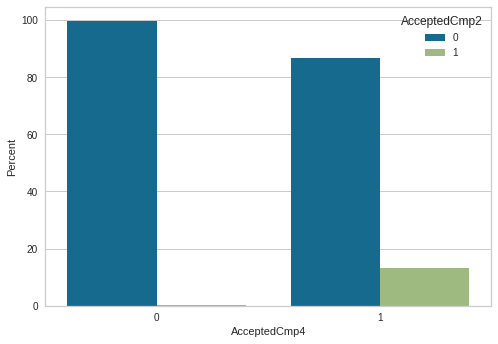

In [93]:
sns.barplot(x="AcceptedCmp4",
            y="Percent", 
            hue="AcceptedCmp2",
            data=df_marketing_EDA_02\
            .groupby("AcceptedCmp4")["AcceptedCmp2"]\
            .value_counts(normalize=True)\
            .mul(100).rename("Percent")\
            .reset_index())

* Praticamente 15% do grupo que aceitou a oferta na quarta campanha aceitou também ofertas na segunda campanha.
* Praticamente 100% do grupo que não aceitou a oferta na quarta campanha também não aceitou a oferta na segunda campanha.

## Teenhome

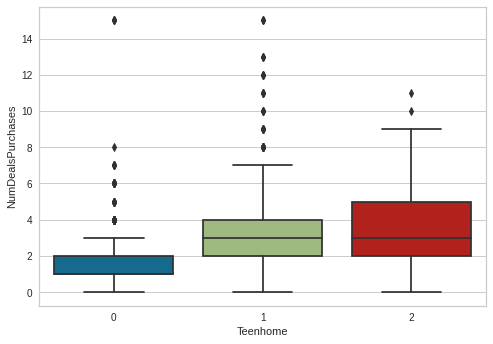

In [94]:
sns.boxplot(x="Teenhome", y="NumDealsPurchases", data=df_marketing_EDA_02)

* A quantidade de compras com desconto é 3 na mediana do grupo que tem um ou dois adolescentes em casa. Assim, vou criar uma coluna booleana, se o cliente tem ou não adolescente em casa.

In [95]:
df_marketing_EDA_02["Cat_Teenhome"] = pd.cut(df_marketing_EDA_02['Teenhome'],
                                      bins=[-1, 0, 10],
                                      labels=[False, True]).astype(bool)

In [96]:
df_marketing_EDA_02.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 33 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   ID                         2240 non-null   int64         
 1   Year_Birth                 2240 non-null   int64         
 2   Education                  2240 non-null   object        
 3   Marital_Status             2240 non-null   object        
 4   Income                     2216 non-null   float64       
 5   Kidhome                    2240 non-null   int64         
 6   Teenhome                   2240 non-null   int64         
 7   Dt_Customer                2240 non-null   datetime64[ns]
 8   Recency                    2240 non-null   int64         
 9   MntWines                   2240 non-null   int64         
 10  MntFruits                  2240 non-null   int64         
 11  MntMeatProducts            2240 non-null   int64         
 12  MntFis

### Teenhome X Response

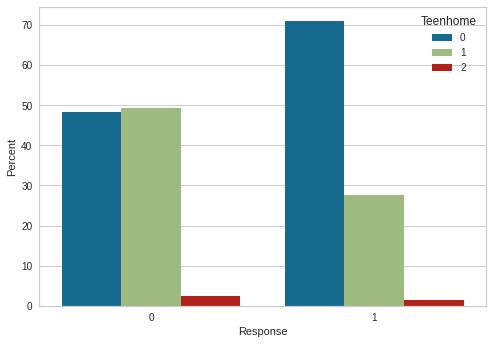

In [97]:
sns.barplot(x="Response",
            y="Percent", 
            hue="Teenhome",
            data=df_marketing_EDA_02\
            .groupby("Response")["Teenhome"]\
            .value_counts(normalize=True)\
            .mul(100).rename("Percent")\
            .reset_index())

* Praticamente 70% dos que aceitaram a oferta na última campanha não têm adolescente em casa.
* Praticamente 50% dos que não aceitaram a oferta na última campanha não têm adolescente em casa.

### Teenhome X NumDealsPurchases

In [98]:
df_marketing_EDA_02

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response,Cat_num_catalog_purchases,cat_kidhome,cat_num_web_visits_month,Cat_Teenhome
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1,High_purchase,False,High_visits,False
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,3,11,0,Low_purchase,True,High_visits,True
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,3,11,0,Low_purchase,False,Low_visits,False
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,3,11,0,Low_purchase,True,High_visits,False
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,3,11,0,Low_purchase,True,High_visits,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,10870,1967,Graduation,Married,61223.0,0,1,2013-06-13,46,709,43,182,42,118,247,2,9,3,4,5,0,0,0,0,0,0,3,11,0,Low_purchase,False,High_visits,True
2236,4001,1946,PhD,Together,64014.0,2,1,2014-06-10,56,406,0,30,0,0,8,7,8,2,5,7,0,0,0,1,0,0,3,11,0,Low_purchase,True,High_visits,True
2237,7270,1981,Graduation,Divorced,56981.0,0,0,2014-01-25,91,908,48,217,32,12,24,1,2,3,13,6,0,1,0,0,0,0,3,11,0,Low_purchase,False,High_visits,False
2238,8235,1956,Master,Together,69245.0,0,1,2014-01-24,8,428,30,214,80,30,61,2,6,5,10,3,0,0,0,0,0,0,3,11,0,Low_purchase,False,Low_visits,True


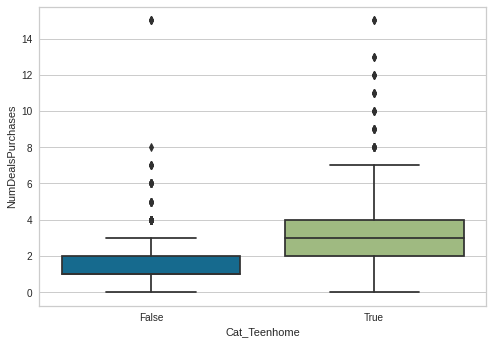

In [99]:
sns.boxplot(x="Cat_Teenhome", y="NumDealsPurchases", data=df_marketing_EDA_02)

* Pelo gráfico, o grupo de clientes que tem adolescentes em casa compram mais, na mediana, com desconto em relação aos clientes que não têm adolescentes em casa. Essa diferença é significativa?
* **A hipótese nula**: o grupo de clientes que tem adolescentes em casa compram igualmente, na mediana, com desconto em relação aos clientes que não têm adolescentes em casa.

In [100]:
hypothesis_test(df_marketing_EDA_02[df_marketing_EDA_02["Cat_Teenhome"]==False]["NumDealsPurchases"],
                df_marketing_EDA_02[df_marketing_EDA_02["Cat_Teenhome"]==True]["NumDealsPurchases"])

Teste de Shapiro-Wilk: valor-p do grupo A: 0.000, valor-p do Grupo B: 0.000.
O Teste de Shapiro-Wilk demonstrou que, no mínimo, algum dos dois grupos não tem distribuição normal dos dados.
Teste de Mann-Whitney-U: stats: 293159.000, valor-p: 0.000.
O teste Mann-Whitney-U demonstrou diferença significativa das medianas dos dois grupos: p-valor de 0.000.


* **A hipótese nula foi rejeitada** de acordo com o teste de Mann-Whitney-U, desde que o valor-p<=0.05.
*Logo, escolhi **a hipótese alternativa**: o grupo de clientes que tem adolescentes em casa compram diferentemente, na mediana, com desconto em relação aos clientes que não têm adolescentes em casa.

### Teenhome X Age

* Para facilitar a análise, irei criar a coluna Age a partir do Year_Birth e a data atual.

In [101]:
from datetime import date

In [102]:
df_marketing_EDA_02["Age"] = date.today().year - df_marketing_EDA_02["Year_Birth"]  

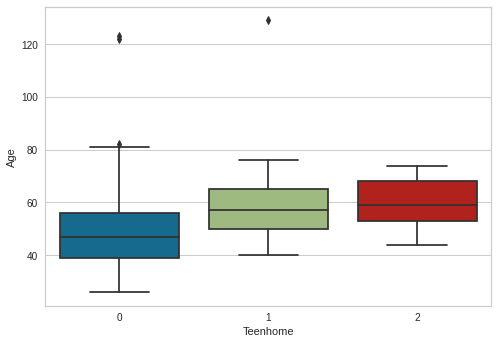

In [103]:
sns.boxplot(x="Teenhome", y="Age", data=df_marketing_EDA_02)

* Há alguns outliers na base em relação ao ano de nascimento do cliente.
  * Um cliente teria 120 anos? Provavelmente não.
  * Um outro cliente teria 125 anos? Provavelmente não. 
  * No pré-processamento essas observações precisam ser removidas, porque possivelmente foi erro de digitação.
* No boxplot, não há muita diferença entre ter um ou dois adolescentes em casa de acordo com a mediana do Age. O cliente com adolescente em casa tem, na mediana, 60 anos aproximadamente. O cliente sem adolescente em casa tem, na mediana, aproximadamente 50 anos. Será mais adequado agrupar em apenas dois grupos, se há adolescente em casa ou não.

In [104]:
df_marketing_EDA_02["Cat_teenhome"] = pd.cut(df_marketing_EDA_02["Teenhome"],
                                             bins=[-1, 0, 10],
                                             labels=[False, True])

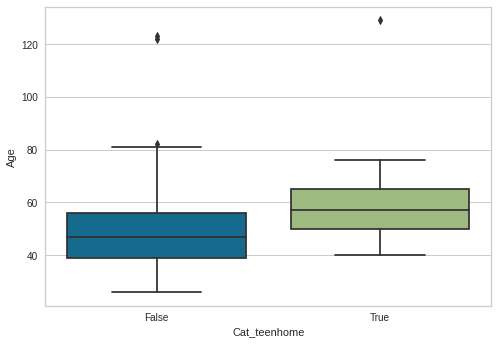

In [105]:
sns.boxplot(x="Cat_teenhome", y="Age", data=df_marketing_EDA_02)

* **Hipótese nula**: o grupo com adolescente em casa tem, na mediana, a mesma idade que o grupo sem adolescente em casa.

In [106]:
hypothesis_test(df_marketing_EDA_02[df_marketing_EDA_02["Cat_teenhome"]==False]["Year_Birth"],
                df_marketing_EDA_02[df_marketing_EDA_02["Cat_teenhome"]==True]["Year_Birth"])

Teste de Shapiro-Wilk: valor-p do grupo A: 0.000, valor-p do Grupo B: 0.000.
O Teste de Shapiro-Wilk demonstrou que, no mínimo, algum dos dois grupos não tem distribuição normal dos dados.
Teste de Mann-Whitney-U: stats: 904885.500, valor-p: 0.000.
O teste Mann-Whitney-U demonstrou diferença significativa das medianas dos dois grupos: p-valor de 0.000.


* De acordo com o teste de Mann-Whitney-U, a **hipótese nula foi rejeitada**, desde que o valor-p<=0.05.
* Logo, escolhi a **hipótese alternativa**: o grupo com adolescente em casa tem, na mediana, idade diferente que o grupo sem adolescente em casa.
* O grupo com adolescente em casa é mais velho, na mediana, que o grupo sem adolescente em casa.

# Resumo dos insights

## Outliers
* Há outliers de erro de digitação em relação à idade, **Age** acima de 120 anos.
* Há um outlier de erro de digitação em relação à renda anual, **Income** igual a 666 666.


## Campanhas



* **27.5%** do grupo, que aceitou a oferta na última campanha, aceitou a oferta na quinta campanha.
* **40%** dos clientes, que aceitaram a oferta na quinta campanha, aceitaram também a oferta na primeira campanha.
* **23%** do grupo, que aceitou a oferta na última campanha, aceitou também oferta na primeira campanha.
* **23%** do grupo, que aceitou a oferta na última campanha, aceitou também oferta na terceira campanha.
* **18.5%** do grupo, que aceitou a oferta na última campanha, aceitou também oferta na quarta campanha.
* **15%** do grupo, que aceitou a oferta na quarta campanha, aceitou também oferta na segunda campanha.
* O grupo que aceitou a oferta na **quinta campanha tem quase 5 vezes mais gastos de vinhos** nos últimos 2 anos na mediana do que o grupo que não aceitou a oferta na quinta campanha
* **Os clientes que aceitaram a oferta na quarta campanha gastam mais em vinho** que aqueles que não aceitaram na quarta campanha.
* Como os gastos em vinho estão relacionados às outras variáveis?

## Padrões de comportamento e hábitos de consumo
* Pela correlação por múltiplos métodos, os gastos de vinho e carne estão nas top 11 correlações com a variável Response. 
---
### Vinho
* **Os clientes que aceitaram a oferta na última campanha gastaram mais em vinho** nos últimos dois anos do que os clientes que não aceitaram a oferta na última campanha. 
* **O grupo que aceitou a oferta na última campanha, na mediana, comprou pelo catálogo mais** do que o grupo que não aceitou a oferta na última campanha.
* **O grupo que não tem criança em casa compra mais vinho** na mediana do que o grupo com crianças em casa.
* E os gastos de carne?
---
### Carne
* **O grupo que aceitou a oferta na última campanha gastou mais em carne** nos últimos 2 anos do que o grupo que não aceitou a oferta na última campanha. 
* **O grupo que compra muito pelo catálogo, na mediana, gasta mais em carne** nos últimos dois anos em relação ao grupo que compra pouco pelo catálogo.
* **O grupo de baixas visitas mensais pela web gastou mais em carne** nos últimos dois anos em relação ao grupo de altas visitas mensais pela web.
* As baixas visitas mensais pela web estão relacionadas ao alto consumo pelo catálogo?
---
### Compras pelo catálogo
* **O grupo de baixas visitas mensais pela web comprou mais através do catálogo** em relação ao grupo de altas visitas mensais pela web.
* **O grupo que aceitou a oferta na última campanha comprou mais produtos pelo catálogo** do que o grupo que não aceitou a oferta na última campanha.
--- 
* Pela correlação por múltiplos métodos, ter ou não adolescente em casa é relevante para a variável Response.
### Teenhome
* **70%** dos que aceitaram a oferta na última campanha **não têm adolescente em casa.**
* **50%** dos que não aceitaram a oferta na última campanha não têm adolescente em casa.
* **O grupo de clientes que tem adolescentes em casa compram mais, na mediana, com desconto** em relação aos clientes que não têm adolescentes em casa.
* **O grupo com adolescente em casa é mais velho**, na mediana, que o grupo sem adolescente em casa.


# Seleção das variáveis

In [107]:
df_marketing_EDA_02.columns

Index(['ID', 'Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome',
       'Teenhome', 'Dt_Customer', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain', 'Z_CostContact', 'Z_Revenue', 'Response',
       'Cat_num_catalog_purchases', 'cat_kidhome', 'cat_num_web_visits_month',
       'Cat_Teenhome', 'Age', 'Cat_teenhome'],
      dtype='object')

In [108]:
features = ["Age", 
            "cat_kidhome", 
            "Cat_teenhome", 
            "MntWines", 
            "MntMeatProducts", 
            "NumDealsPurchases", 
            "Cat_num_catalog_purchases",
            "cat_num_web_visits_month",
            "AcceptedCmp1",
            "AcceptedCmp2",
            "AcceptedCmp3",
            "AcceptedCmp4",
            "AcceptedCmp5",
            "Response"]

In [109]:
df_marketing_selected_features = df_marketing_EDA_02[features].copy()

In [110]:
df_marketing_selected_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   Age                        2240 non-null   int64   
 1   cat_kidhome                2240 non-null   category
 2   Cat_teenhome               2240 non-null   category
 3   MntWines                   2240 non-null   int64   
 4   MntMeatProducts            2240 non-null   int64   
 5   NumDealsPurchases          2240 non-null   int64   
 6   Cat_num_catalog_purchases  2240 non-null   category
 7   cat_num_web_visits_month   2240 non-null   category
 8   AcceptedCmp1               2240 non-null   int64   
 9   AcceptedCmp2               2240 non-null   int64   
 10  AcceptedCmp3               2240 non-null   int64   
 11  AcceptedCmp4               2240 non-null   int64   
 12  AcceptedCmp5               2240 non-null   int64   
 13  Response                   2240 n

#Pré-processamento 02

In [111]:
df_marketing_preprocessing_02 = df_marketing_selected_features.copy()

In [112]:
df_marketing_preprocessing_02.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   Age                        2240 non-null   int64   
 1   cat_kidhome                2240 non-null   category
 2   Cat_teenhome               2240 non-null   category
 3   MntWines                   2240 non-null   int64   
 4   MntMeatProducts            2240 non-null   int64   
 5   NumDealsPurchases          2240 non-null   int64   
 6   Cat_num_catalog_purchases  2240 non-null   category
 7   cat_num_web_visits_month   2240 non-null   category
 8   AcceptedCmp1               2240 non-null   int64   
 9   AcceptedCmp2               2240 non-null   int64   
 10  AcceptedCmp3               2240 non-null   int64   
 11  AcceptedCmp4               2240 non-null   int64   
 12  AcceptedCmp5               2240 non-null   int64   
 13  Response                   2240 n

## Renomear colunas

In [113]:
df_marketing_preprocessing_02 = df_marketing_selected_features.rename(columns={"cat_kidhome": "Cat_kidhome",
                                                                               "Cat_num_catalog_purchases": "High_num_catalog_purchases",
                                                                               "cat_num_web_visits_month": "Low_num_web_visits_month"})

In [114]:
#Low_num_web_visits_month precisa ser transformada em boleano
df_marketing_preprocessing_02["Low_num_web_visits_month"] = df_marketing_preprocessing_02["Low_num_web_visits_month"].astype("object")
df_marketing_preprocessing_02.loc[df_marketing_preprocessing_02["Low_num_web_visits_month"]=="Low_visits", "Low_num_web_visits_month"] = "1"
df_marketing_preprocessing_02.loc[df_marketing_preprocessing_02["Low_num_web_visits_month"]=="High_visits", "Low_num_web_visits_month"] = "0"
df_marketing_preprocessing_02["Low_num_web_visits_month"] = df_marketing_preprocessing_02["Low_num_web_visits_month"].astype(int).astype(bool)

#High_num_catalog_purchases precisa ser transformada em boleano
df_marketing_preprocessing_02["High_num_catalog_purchases"] = df_marketing_preprocessing_02["High_num_catalog_purchases"].astype("object")
df_marketing_preprocessing_02.loc[df_marketing_preprocessing_02["High_num_catalog_purchases"]=="High_purchase", "High_num_catalog_purchases"] = "1"
df_marketing_preprocessing_02.loc[df_marketing_preprocessing_02["High_num_catalog_purchases"]=="Low_purchase", "High_num_catalog_purchases"] = "0"
df_marketing_preprocessing_02["High_num_catalog_purchases"] = df_marketing_preprocessing_02["High_num_catalog_purchases"].astype(int).astype(bool)


In [115]:
df_marketing_preprocessing_02["High_num_catalog_purchases"].value_counts()

False    1993
True      247
Name: High_num_catalog_purchases, dtype: int64

In [116]:
df_marketing_preprocessing_02["Low_num_web_visits_month"].value_counts()

False    1451
True      789
Name: Low_num_web_visits_month, dtype: int64

## Transformar tipos de dados

In [117]:
df_marketing_preprocessing_02["Cat_kidhome"] = df_marketing_preprocessing_02["Cat_kidhome"].astype(bool)
df_marketing_preprocessing_02["Cat_teenhome"] = df_marketing_preprocessing_02["Cat_teenhome"].astype(bool)
df_marketing_preprocessing_02["AcceptedCmp1"] = df_marketing_preprocessing_02["AcceptedCmp1"].astype(bool)
df_marketing_preprocessing_02["AcceptedCmp2"] = df_marketing_preprocessing_02["AcceptedCmp2"].astype(bool)
df_marketing_preprocessing_02["AcceptedCmp3"] = df_marketing_preprocessing_02["AcceptedCmp3"].astype(bool)
df_marketing_preprocessing_02["AcceptedCmp4"] = df_marketing_preprocessing_02["AcceptedCmp4"].astype(bool)
df_marketing_preprocessing_02["AcceptedCmp5"] = df_marketing_preprocessing_02["AcceptedCmp5"].astype(bool)
df_marketing_preprocessing_02["Response"] = df_marketing_preprocessing_02["Response"].astype(bool)

In [118]:
df_marketing_preprocessing_02.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   Age                         2240 non-null   int64
 1   Cat_kidhome                 2240 non-null   bool 
 2   Cat_teenhome                2240 non-null   bool 
 3   MntWines                    2240 non-null   int64
 4   MntMeatProducts             2240 non-null   int64
 5   NumDealsPurchases           2240 non-null   int64
 6   High_num_catalog_purchases  2240 non-null   bool 
 7   Low_num_web_visits_month    2240 non-null   bool 
 8   AcceptedCmp1                2240 non-null   bool 
 9   AcceptedCmp2                2240 non-null   bool 
 10  AcceptedCmp3                2240 non-null   bool 
 11  AcceptedCmp4                2240 non-null   bool 
 12  AcceptedCmp5                2240 non-null   bool 
 13  Response                    2240 non-null   bool 
dtypes: bool(

## Remover outliers

In [119]:
df_marketing_preprocessing_02 = df_marketing_preprocessing_02.loc[df_marketing_preprocessing_02["Age"]<115]

In [120]:
df_marketing_preprocessing_02.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2237 entries, 0 to 2239
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   Age                         2237 non-null   int64
 1   Cat_kidhome                 2237 non-null   bool 
 2   Cat_teenhome                2237 non-null   bool 
 3   MntWines                    2237 non-null   int64
 4   MntMeatProducts             2237 non-null   int64
 5   NumDealsPurchases           2237 non-null   int64
 6   High_num_catalog_purchases  2237 non-null   bool 
 7   Low_num_web_visits_month    2237 non-null   bool 
 8   AcceptedCmp1                2237 non-null   bool 
 9   AcceptedCmp2                2237 non-null   bool 
 10  AcceptedCmp3                2237 non-null   bool 
 11  AcceptedCmp4                2237 non-null   bool 
 12  AcceptedCmp5                2237 non-null   bool 
 13  Response                    2237 non-null   bool 
dtypes: bool(

# Segmentação
* Perguntas a serem respondidas:
  * Quem aceitou mais ofertas da última campanha?
  * Quem mais aceitou ofertas?
  * Quem é o mais jovem?
  * Quem não tem filhos?
  * Quem mais compra pelo catálogo?
  * Quem menos visita o site por mês?
  * Quem gosta mais de desconto?
  * Quem gosta mais de vinho?
  * Quem gosta mais de carne?

In [121]:
df_marketing_segmentation = df_marketing_preprocessing_02.copy()

## Normalizar as variáveis numéricas
* Aplicar Robust scaler, porque esse método é extremamente robusto aos outliers excessivos no dataset, além disso os algoritmos de clustering baseados em variáveis numéricas são sensíveis aos outliers, como o k-means e o k-prototypes.

In [122]:
num_features_robust_scaler = ["Age",
                              "MntWines",
                              "MntMeatProducts",
                              "NumDealsPurchases"]

In [123]:
df_marketing_segmentation.describe()

,Age,MntWines,MntMeatProducts,NumDealsPurchases
count,2237.000000,2237.000000,2237.000000,2237.000000
mean,53.098346,303.995530,166.916853,2.326777
std,11.701917,336.574382,225.661158,1.932923
min,26.000000,0.000000,0.000000,0.000000
25%,45.000000,24.000000,16.000000,1.000000
50%,52.000000,174.000000,67.000000,2.000000
75%,63.000000,504.000000,232.000000,3.000000
max,82.000000,1493.000000,1725.000000,15.000000


* Armazenar o Q1 e Q3 das variáveis numéricas e a mediana para as variáveis serem interpretáveis.

In [124]:
Q1_Age = 45
Q3_Age = 63
Median_Age = df_marketing_segmentation["Age"].median()

Q1_MntWines = 24
Q3_MntWines = 504
Median_MntWines = df_marketing_segmentation["MntWines"].median()

Q1_MntMeatProducts = 16
Q3_MntMeatProducts = 232
Median_MntMeatProducts = df_marketing_segmentation["MntMeatProducts"].median()

Q1_NumDealsPurchases = 1
Q3_NumDealsPurchases = 3
Median_NumDealsPurchases = df_marketing_segmentation["NumDealsPurchases"].median()



In [125]:
df_marketing_segmentation[num_features_robust_scaler] = RobustScaler().fit_transform(df_marketing_segmentation[num_features_robust_scaler])

In [126]:
df_marketing_segmentation.head(3)

,Age,Cat_kidhome,Cat_teenhome,MntWines,MntMeatProducts,NumDealsPurchases,High_num_catalog_purchases,Low_num_web_visits_month,AcceptedCmp1,AcceptedCmp2,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,Response
0,0.722222,False,False,0.960417,2.217593,0.5,True,False,False,False,False,False,False,True
1,0.888889,True,True,-0.339583,-0.282407,0.0,False,False,False,False,False,False,False,False
2,0.277778,False,False,0.525000,0.277778,-0.5,False,True,False,False,False,False,False,False


## Clusterização
* O dataset é composto por variáveis numéricas e categóricas, logo a melhor opção para agrupar os clientes é pelo K-Prototypes, que é a combinação de K-Means e K-Modes.

### Análise do cluster pelo método do cotovelo

In [127]:
df_marketing_segmentation.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2237 entries, 0 to 2239
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Age                         2237 non-null   float64
 1   Cat_kidhome                 2237 non-null   bool   
 2   Cat_teenhome                2237 non-null   bool   
 3   MntWines                    2237 non-null   float64
 4   MntMeatProducts             2237 non-null   float64
 5   NumDealsPurchases           2237 non-null   float64
 6   High_num_catalog_purchases  2237 non-null   bool   
 7   Low_num_web_visits_month    2237 non-null   bool   
 8   AcceptedCmp1                2237 non-null   bool   
 9   AcceptedCmp2                2237 non-null   bool   
 10  AcceptedCmp3                2237 non-null   bool   
 11  AcceptedCmp4                2237 non-null   bool   
 12  AcceptedCmp5                2237 non-null   bool   
 13  Response                    2237 

In [128]:
categorical_features = [1, 2, 6, 7, 8, 9, 10, 11, 12, 13]

In [129]:
# Não rodar múltiplas vezes pelo custo computacional
%%script echo skipping
# Fitando vários modelos e armazenando inércia na lista SSE
SSE = []
for cluster in range(2, 20):  
  k_proto = KPrototypes(n_clusters=cluster, max_iter=100, init="Cao", n_init=10, random_state=0)
  k_proto.fit(df_marketing_segmentation, categorical=categorical_features)
  SSE.append(k_proto.cost_)

# Convertendo os resultados em um dataframe
frame = pd.DataFrame({'Cluster': range(2, 20),
                      'SSE': SSE})
plt.figure(figsize=(5, 5))
plt.plot(frame['Cluster'], frame['SSE'], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

skipping


![](https://drive.google.com/uc?export=view&id=1NTYn_ripUcQIP6AokD7o-_6r5-QjeTnA)

* A inércia continua caindo do 2 até o 20.
* A curva está muito suave o que dificulta o número de clusters ótimo.
* Visualmente, a partir do 7, há uma mudança de inclinação da inércia.
* Farei pelo método da silhueta.

### Análise do cluster pelo método da silhueta

In [130]:
from sklearn.metrics import silhouette_score

In [131]:
# Não rodar múltiplas vezes pelo custo computacional
%%script echo skipping
# Fitando vários modelos e armazenando inércia na lista SSE
SSE = []
for cluster in range(2, 20):  
  k_proto = KPrototypes(n_clusters=cluster, max_iter=100, init="Cao", n_init=10, random_state=0)
  label = k_proto.fit_predict(df_marketing_segmentation, categorical=categorical_features)
  SSE.append(silhouette_score(df_marketing_segmentation, label))

# Convertendo os resultados em um dataframe
frame = pd.DataFrame({'Cluster': range(2, 20),
                      'SSE': SSE})
plt.figure(figsize=(5, 5))
plt.plot(frame['Cluster'], frame['SSE'], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')

skipping


![](https://drive.google.com/uc?export=view&id=1hUyXpOyS9pQ0l4fBvQZ5Xc9_gLes0CDj)


* O cluster com a melhor silhueta escore foi o 2 com 0.325, essa pontuação foi ruim em uma escala de -1 a 1, isso significa que os clusters estão sobrepostos.
* O cluster com a segunda melhor silhueta escore foi o 3.
* O cluster com a terceira melhor silhueta escore foi o 4.
* O cluster com a quarta melhor silhueta escore foi o 5 e 7.

### Visualização por t-sne

In [132]:
from sklearn.manifold import TSNE

In [133]:
df_marketing_segmentation.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2237 entries, 0 to 2239
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Age                         2237 non-null   float64
 1   Cat_kidhome                 2237 non-null   bool   
 2   Cat_teenhome                2237 non-null   bool   
 3   MntWines                    2237 non-null   float64
 4   MntMeatProducts             2237 non-null   float64
 5   NumDealsPurchases           2237 non-null   float64
 6   High_num_catalog_purchases  2237 non-null   bool   
 7   Low_num_web_visits_month    2237 non-null   bool   
 8   AcceptedCmp1                2237 non-null   bool   
 9   AcceptedCmp2                2237 non-null   bool   
 10  AcceptedCmp3                2237 non-null   bool   
 11  AcceptedCmp4                2237 non-null   bool   
 12  AcceptedCmp5                2237 non-null   bool   
 13  Response                    2237 

In [134]:
k_proto = KPrototypes(n_clusters=5, max_iter=100, init="Cao", n_init=10, random_state=0)
kp_labels = k_proto.fit_predict(df_marketing_segmentation, categorical=categorical_features)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


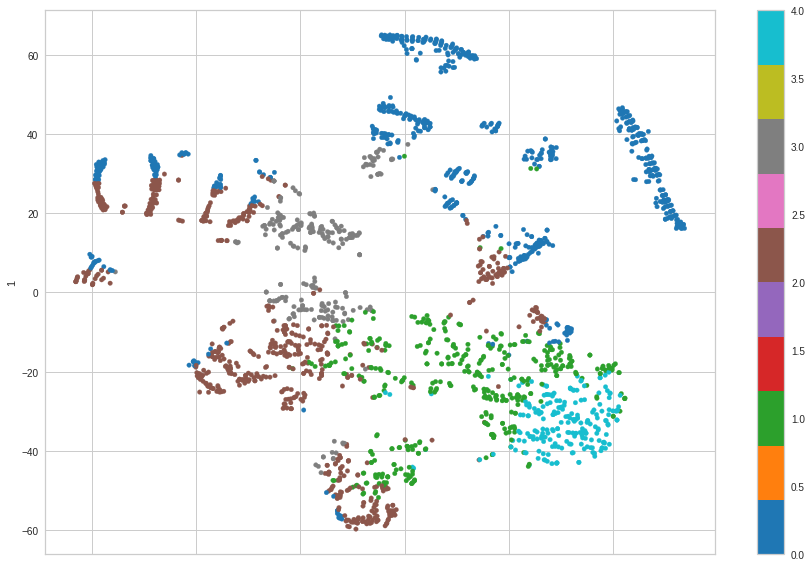

In [135]:
df_TSNE = TSNE(random_state=0).fit_transform(df_marketing_segmentation)
pd.DataFrame(df_TSNE).plot.scatter(x=0, y=1, c=kp_labels, colormap='tab10', figsize=(15,10))
plt.show()

* É possível visualizar pequenos e grandes clusters pelo t-sne.
* Os clusters estão bem mal formados.


### Justificativa de clusters escolhidos
* Pelo método do cotovelo, 7 seria um ponto ótimo para o cluster, e a quarta melhor silhueta está entre 5 e 7, se eu escolher 7 grupos de clientes, a equipe de marketing irá conseguir acompanhar 7 jornadas de tipos de clientes ao mesmo tempo? Talvez não faça sentido acompanhar 7 grupos, porque são apenas 7 perguntas principais a serem respondidas, sendo que a maior parte delas estão relacionadas às features transformadas em boleano, o que diminui a possibilidade de ter clusters tão únicos.

* Por conta disso, o número de clusters escolhidos foi 5.


In [136]:
all_features = df_marketing_segmentation.columns.to_list()

In [137]:
df_marketing_segmentation[all_features].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2237 entries, 0 to 2239
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Age                         2237 non-null   float64
 1   Cat_kidhome                 2237 non-null   bool   
 2   Cat_teenhome                2237 non-null   bool   
 3   MntWines                    2237 non-null   float64
 4   MntMeatProducts             2237 non-null   float64
 5   NumDealsPurchases           2237 non-null   float64
 6   High_num_catalog_purchases  2237 non-null   bool   
 7   Low_num_web_visits_month    2237 non-null   bool   
 8   AcceptedCmp1                2237 non-null   bool   
 9   AcceptedCmp2                2237 non-null   bool   
 10  AcceptedCmp3                2237 non-null   bool   
 11  AcceptedCmp4                2237 non-null   bool   
 12  AcceptedCmp5                2237 non-null   bool   
 13  Response                    2237 

In [138]:
all_features = df_marketing_segmentation.columns.to_list()

categorical_features = [1, 2, 6, 7, 8, 9, 10, 11, 12, 13]

In [139]:
k_proto = KPrototypes(n_clusters=5, max_iter=100, init="Cao", n_init=10, random_state=0)
df_marketing_segmentation["Cluster_k_prototypes"] = k_proto.fit_predict(df_marketing_segmentation, categorical=categorical_features)

### Sumarização dos clusters

In [140]:
df_marketing_segmentation.columns

Index(['Age', 'Cat_kidhome', 'Cat_teenhome', 'MntWines', 'MntMeatProducts',
       'NumDealsPurchases', 'High_num_catalog_purchases',
       'Low_num_web_visits_month', 'AcceptedCmp1', 'AcceptedCmp2',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'Response',
       'Cluster_k_prototypes'],
      dtype='object')

In [141]:
from statistics import mode
df_marketing_segmentation_summary = df_marketing_segmentation.groupby("Cluster_k_prototypes").agg({"Age": lambda a:a.mean(),
                                                                                                  "NumDealsPurchases": lambda p:p.mean(),
                                                                                                  "MntWines": lambda w:w.mean(),
                                                                                                  "MntMeatProducts": lambda m:m.mean(),
                                                                                                  "Cat_kidhome": lambda k:k.mode(),
                                                                                                  "Cat_teenhome": lambda t:t.mode(),
                                                                                                  "High_num_catalog_purchases": lambda h:h.mode(),
                                                                                                  "Low_num_web_visits_month": lambda w:w.mode(),
                                                                                                   "AcceptedCmp1": lambda a:a.mode(),
                                                                                                   "AcceptedCmp2": lambda a:a.mode(),
                                                                                                   "AcceptedCmp3": lambda a:a.mode(),
                                                                                                   "AcceptedCmp4": lambda a:a.mode(),
                                                                                                  "AcceptedCmp5": lambda a:a.mode(),
                                                                                                  "Response": lambda r:r.mode()}).reset_index()

In [142]:
df_marketing_segmentation_summary

,Cluster_k_prototypes,Age,NumDealsPurchases,MntWines,MntMeatProducts,Cat_kidhome,Cat_teenhome,High_num_catalog_purchases,Low_num_web_visits_month,AcceptedCmp1,AcceptedCmp2,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,Response
0,0,-0.461079,-0.094477,-0.274849,-0.176464,True,False,False,False,False,False,False,False,False,False
1,1,0.171143,-0.232227,1.048657,1.079845,False,False,False,True,False,False,False,False,False,False
2,2,0.516467,0.113772,0.060220,-0.017659,False,True,False,False,False,False,False,False,False,False
3,3,0.145299,2.281377,0.403568,0.350146,True,True,False,False,False,False,False,False,False,False
4,4,0.002883,-0.523585,1.002300,2.951935,False,False,False,True,False,False,False,False,False,False


### Número dos clusters padronizados para rodar o experimento
* Um grande problema do k-protypes é o fato de mudar aleatoriamente o número do cluster mesmo com a semente aleatória fixa e o tipo de inicialização. Para padronizar o experimento deste notebook, é necessário criar filtros de acordo com a característica de cada cluster analisado.

In [143]:
clustering_0 = df_marketing_segmentation_summary.loc[(df_marketing_segmentation_summary["Age"]<-0.45), "Cluster_k_prototypes"]

df_marketing_segmentation_summary.loc[(df_marketing_segmentation_summary["Age"]<-0.45), "Cluster_k_prototypes"] = 0 

clustering_1 = df_marketing_segmentation_summary.loc[(df_marketing_segmentation_summary["Age"]>0.16) \
                                                     & (df_marketing_segmentation_summary["Age"]<0.18), "Cluster_k_prototypes"]

df_marketing_segmentation_summary.loc[(df_marketing_segmentation_summary["Age"]>0.16) \
                                                     & (df_marketing_segmentation_summary["Age"]<0.18), "Cluster_k_prototypes"]=1

clustering_2 = df_marketing_segmentation_summary.loc[(df_marketing_segmentation_summary["Age"]>0.5) \
                                                     & (df_marketing_segmentation_summary["Age"]<0.52), 
                                                     "Cluster_k_prototypes"]
                                                     
df_marketing_segmentation_summary.loc[(df_marketing_segmentation_summary["Age"]>0.5) \
                                      & (df_marketing_segmentation_summary["Age"]<0.52), 
                                      "Cluster_k_prototypes"]=2                                                    

clustering_3 = df_marketing_segmentation_summary.loc[(df_marketing_segmentation_summary["Age"]>0.14) \
                                                     & (df_marketing_segmentation_summary["Age"]<0.15), 
                                                     "Cluster_k_prototypes"]
                                                     
df_marketing_segmentation_summary.loc[(df_marketing_segmentation_summary["Age"]>0.14) \
                                      & (df_marketing_segmentation_summary["Age"]<0.15), 
                                      "Cluster_k_prototypes"]=3

clustering_4 = df_marketing_segmentation_summary.loc[(df_marketing_segmentation_summary["Age"]>0.00) \
                                                     & (df_marketing_segmentation_summary["Age"]<0.01), 
                                                     "Cluster_k_prototypes"]
                                                     
df_marketing_segmentation_summary.loc[(df_marketing_segmentation_summary["Age"]>0.00) \
                                      & (df_marketing_segmentation_summary["Age"]<0.01), 
                                      "Cluster_k_prototypes"]=4

In [144]:
df_marketing_segmentation_summary = df_marketing_segmentation_summary.sort_values(by='Cluster_k_prototypes').set_index("Cluster_k_prototypes")

In [145]:
df_marketing_segmentation_summary

,Age,NumDealsPurchases,MntWines,MntMeatProducts,Cat_kidhome,Cat_teenhome,High_num_catalog_purchases,Low_num_web_visits_month,AcceptedCmp1,AcceptedCmp2,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,Response
Cluster_k_prototypes,,,,,,,,,,,,,,
0,-0.461079,-0.094477,-0.274849,-0.176464,True,False,False,False,False,False,False,False,False,False
1,0.171143,-0.232227,1.048657,1.079845,False,False,False,True,False,False,False,False,False,False
2,0.516467,0.113772,0.060220,-0.017659,False,True,False,False,False,False,False,False,False,False
3,0.145299,2.281377,0.403568,0.350146,True,True,False,False,False,False,False,False,False,False
4,0.002883,-0.523585,1.002300,2.951935,False,False,False,True,False,False,False,False,False,False


* É perceptível que as classes desbalanceadas da High_num_catalog_purchases, AcceptedCmp1, AcceptedCmp2, AcceptedCmp3, AcceptedCmp4, AcceptedCmp5 e Response influenciaram negativamente na clusterização. Uma criação artificial de dados é necessária para melhorar a clusterização e dar maiores insights sobre o segmento.


### Criação artificial de clientes

#### Rebalanceamento de dataset
* As colunas que não foram detectadas bem na clusterização fazem parte de um problema de multi-rótulos com várias colunas de apenas duas respostas: 0 e 1. Uma solução seria combinar todas essas colunas em uma única coluna chamada de "Multi_class".

#### Combinações valores possíveis em uma coluna

In [146]:
df_marketing_segmentation_multilabel = df_marketing_segmentation[["High_num_catalog_purchases", 
                                                                  "AcceptedCmp1", 
                                                                  "AcceptedCmp2",
                                                                  "AcceptedCmp3",
                                                                  "AcceptedCmp4",
                                                                  "AcceptedCmp5",
                                                                  "Response"]].copy()

In [147]:
df_marketing_segmentation_multilabel.astype(int).value_counts().index.values.shape

(62,)

* São 62 classes para a nova coluna.

In [148]:
df_marketing_segmentation.head(3)

,Age,Cat_kidhome,Cat_teenhome,MntWines,MntMeatProducts,NumDealsPurchases,High_num_catalog_purchases,Low_num_web_visits_month,AcceptedCmp1,AcceptedCmp2,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,Response,Cluster_k_prototypes
0,0.722222,False,False,0.960417,2.217593,0.5,True,False,False,False,False,False,False,True,4
1,0.888889,True,True,-0.339583,-0.282407,0.0,False,False,False,False,False,False,False,False,2
2,0.277778,False,False,0.525000,0.277778,-0.5,False,True,False,False,False,False,False,False,1


#### Feature Engineering

In [149]:
!pip install imblearn
import imblearn

In [150]:
df_marketing_segmentation.head(3)

,Age,Cat_kidhome,Cat_teenhome,MntWines,MntMeatProducts,NumDealsPurchases,High_num_catalog_purchases,Low_num_web_visits_month,AcceptedCmp1,AcceptedCmp2,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,Response,Cluster_k_prototypes
0,0.722222,False,False,0.960417,2.217593,0.5,True,False,False,False,False,False,False,True,4
1,0.888889,True,True,-0.339583,-0.282407,0.0,False,False,False,False,False,False,False,False,2
2,0.277778,False,False,0.525000,0.277778,-0.5,False,True,False,False,False,False,False,False,1


In [151]:
df_marketing_segmentation["multi_class"] = df_marketing_segmentation["High_num_catalog_purchases"].astype(str) \
+ "_" + df_marketing_segmentation["AcceptedCmp1"].astype(str) \
+ "_" + df_marketing_segmentation["AcceptedCmp2"].astype(str) \
+ "_" + df_marketing_segmentation["AcceptedCmp3"].astype(str) \
+ "_" + df_marketing_segmentation["AcceptedCmp4"].astype(str) \
+ "_" + df_marketing_segmentation["AcceptedCmp5"].astype(str) \
+ "_" + df_marketing_segmentation["Response"].astype(str)

#### RandomOverSampler

In [152]:
from imblearn.over_sampling import RandomOverSampler

y_segmentation = df_marketing_segmentation["multi_class"]

X_segmentation = df_marketing_segmentation[["Age",	
                                           'Cat_kidhome',
                                           'Cat_teenhome',
                                           'MntWines',
                                           'MntMeatProducts',
                                           'NumDealsPurchases',
                                           'Low_num_web_visits_month']]

oversampler = RandomOverSampler(sampling_strategy="minority", random_state=0)
X_balanced_segmentation, y_balanced_segmentation = oversampler.fit_resample(X_segmentation, y_segmentation)

In [153]:
X_balanced_segmentation.head(3)

,Age,Cat_kidhome,Cat_teenhome,MntWines,MntMeatProducts,NumDealsPurchases,Low_num_web_visits_month
0,0.722222,False,False,0.960417,2.217593,0.5,False
1,0.888889,True,True,-0.339583,-0.282407,0.0,False
2,0.277778,False,False,0.525000,0.277778,-0.5,True


In [154]:
y_balanced_segmentation.head(3)

0      True_False_False_False_False_False_True
1    False_False_False_False_False_False_False
2    False_False_False_False_False_False_False
Name: multi_class, dtype: object

In [155]:
df_balanced_segmentation = pd.concat([X_balanced_segmentation, y_balanced_segmentation], axis=1)

In [156]:
df_balanced_segmentation.head(3)

,Age,Cat_kidhome,Cat_teenhome,MntWines,MntMeatProducts,NumDealsPurchases,Low_num_web_visits_month,multi_class
0,0.722222,False,False,0.960417,2.217593,0.5,False,True_False_False_False_False_False_True
1,0.888889,True,True,-0.339583,-0.282407,0.0,False,False_False_False_False_False_False_False
2,0.277778,False,False,0.525000,0.277778,-0.5,True,False_False_False_False_False_False_False


In [157]:
df_balanced_segmentation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3747 entries, 0 to 3746
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Age                       3747 non-null   float64
 1   Cat_kidhome               3747 non-null   bool   
 2   Cat_teenhome              3747 non-null   bool   
 3   MntWines                  3747 non-null   float64
 4   MntMeatProducts           3747 non-null   float64
 5   NumDealsPurchases         3747 non-null   float64
 6   Low_num_web_visits_month  3747 non-null   bool   
 7   multi_class               3747 non-null   object 
dtypes: bool(3), float64(4), object(1)
memory usage: 157.5+ KB


#### Preparação para sumarização de cluster

In [158]:
categorical_features = [1, 2, 6, 7]

In [159]:
k_proto = KPrototypes(n_clusters=5, max_iter=100, init="Cao", n_init=10, random_state=0)
df_balanced_segmentation["Cluster_k_prototypes_balanceado"] = k_proto.fit_predict(df_balanced_segmentation, categorical=categorical_features)

In [160]:
df_balanced_segmentation_summary = df_balanced_segmentation.groupby("Cluster_k_prototypes_balanceado").agg({"Age": lambda a:a.mean(),
                                                                              "NumDealsPurchases": lambda p:p.mean(),
                                                                              "MntWines": lambda w:w.mean(),
                                                                              "MntMeatProducts": lambda m:m.mean(),
                                                                              "Cat_kidhome": lambda k:k.mode(),
                                                                              "Cat_teenhome": lambda t:t.mode(),
                                                                              "Low_num_web_visits_month": lambda w:w.mode(),
                                                                              "multi_class": lambda mc:mc.mode()})

#### Cluster padronizado para experimento

In [161]:
df_balanced_segmentation_summary.reset_index(inplace=True)

In [162]:
clustering_0 = df_balanced_segmentation_summary.loc[(df_balanced_segmentation_summary["Age"]<-0.41), 
                                                    "Cluster_k_prototypes_balanceado"]

df_balanced_segmentation_summary.loc[(df_balanced_segmentation_summary["Age"]<-0.41), 
                                     "Cluster_k_prototypes_balanceado"] = 0 

clustering_1 = df_balanced_segmentation_summary.loc[(df_balanced_segmentation_summary["Age"]<-0.31) \
                                                     & (df_balanced_segmentation_summary["Age"]>-0.35), 
                                                    "Cluster_k_prototypes_balanceado"]

df_balanced_segmentation_summary.loc[(df_balanced_segmentation_summary["Age"]<-0.31) \
                                                     & (df_balanced_segmentation_summary["Age"]>-0.35), 
                                     "Cluster_k_prototypes_balanceado"]=1

clustering_2 = df_balanced_segmentation_summary.loc[(df_balanced_segmentation_summary["Age"]>0.5) \
                                                     & (df_balanced_segmentation_summary["Age"]<0.55), 
                                                     "Cluster_k_prototypes_balanceado"]
                                                     
df_balanced_segmentation_summary.loc[(df_balanced_segmentation_summary["Age"]>0.5) \
                                      & (df_balanced_segmentation_summary["Age"]<0.55), 
                                      "Cluster_k_prototypes_balanceado"]=2                                                    

clustering_3 = df_balanced_segmentation_summary.loc[(df_balanced_segmentation_summary["Age"]>0.14) \
                                                     & (df_balanced_segmentation_summary["Age"]<0.15), 
                                                     "Cluster_k_prototypes_balanceado"]
                                                     
df_balanced_segmentation_summary.loc[(df_balanced_segmentation_summary["Age"]>0.14) \
                                      & (df_balanced_segmentation_summary["Age"]<0.15), 
                                      "Cluster_k_prototypes_balanceado"]=3

clustering_4 = df_balanced_segmentation_summary.loc[(df_balanced_segmentation_summary["Age"]>0.00) \
                                                     & (df_balanced_segmentation_summary["Age"]<0.01), 
                                                     "Cluster_k_prototypes_balanceado"]
                                                     
df_balanced_segmentation_summary.loc[(df_balanced_segmentation_summary["Age"]>0.00) \
                                      & (df_balanced_segmentation_summary["Age"]<0.1), 
                                      "Cluster_k_prototypes_balanceado"]=4

* Depois de padronizado o experimento para conseguir comparar os clusters com dataset desbalanceado e clusters com rebalanceamento de dataset. Agora chegou o momento de sumarizar.

In [163]:
df_balanced_segmentation_summary = df_balanced_segmentation_summary\
.sort_values(by='Cluster_k_prototypes_balanceado').set_index("Cluster_k_prototypes_balanceado")

In [164]:
df_balanced_segmentation_summary

,Age,NumDealsPurchases,MntWines,MntMeatProducts,Cat_kidhome,Cat_teenhome,Low_num_web_visits_month,multi_class
Cluster_k_prototypes_balanceado,,,,,,,,
0,-0.429774,-0.095845,-0.252603,-0.157656,True,False,False,False_False_False_False_False_False_False
1,-0.316516,-0.000315,2.698676,0.967922,True,False,False,False_False_False_True_False_True_True
2,0.520579,0.079843,0.225076,0.111432,False,True,False,False_False_False_False_False_False_False
3,0.141497,2.287755,0.387466,0.348337,True,True,False,False_False_False_False_False_False_False
4,0.060380,-0.456576,0.909491,2.280248,False,False,True,False_False_False_False_False_False_False


* Interessantemente, o cluster 1 foi o único que aceitou, na moda, alguma campanha! Ele aceitou a última campanha, a quinta e a terceira!
* Qual é a diferença entre os clusters balanceados e não balanceados?

#### Diferença entre Clusters com e sem rebalanceamento.

In [165]:
df_balanced_segmentation_summary["Age"]-df_marketing_segmentation_summary["Age"]

Cluster_k_prototypes_balanceado
0    0.031305
1   -0.487659
2    0.004112
3   -0.003803
4    0.057498
Name: Age, dtype: float64

* Cluster 1: a idade dos clientes foi extremamente afetada pelo rebalanceamento.

In [166]:
df_balanced_segmentation_summary["NumDealsPurchases"]-df_marketing_segmentation_summary["NumDealsPurchases"]

Cluster_k_prototypes_balanceado
0   -0.001368
1    0.231913
2   -0.033930
3    0.006379
4    0.067009
Name: NumDealsPurchases, dtype: float64

* Cluster 1: a quantidade de compras com desconto foi extremamente afetada pelo rebalanceamento também.

In [167]:
df_balanced_segmentation_summary["MntWines"]-df_marketing_segmentation_summary["MntWines"]

Cluster_k_prototypes_balanceado
0    0.022246
1    1.650019
2    0.164856
3   -0.016102
4   -0.092808
Name: MntWines, dtype: float64

* Cluster 1: os gastos de vinho com foi extremamente afetado pelo rebalanceamento.

In [168]:
df_balanced_segmentation_summary["MntMeatProducts"]-df_marketing_segmentation_summary["MntMeatProducts"]

Cluster_k_prototypes_balanceado
0    0.018809
1   -0.111923
2    0.129091
3   -0.001809
4   -0.671687
Name: MntMeatProducts, dtype: float64

* Cluster 1 e 2: os gastos com carne foram moderadamente afetados pelo rebalanceamento.
* CLuster 4: os gastos com carne foram muito afetados rebalancemanto.
* O Cluster 1 de fato contém clientes relevantes para a segmentação de acordo com a sumarização do **Cluster_k_prototypes_balanceado**. Será que filtrar pelo Cluster 1 o dataset **df_marketing_segmentation** e analisá-lo de forma mais aprofundada, é possível encontrar o sub-segmento de clientes mais fiéis?

### Análise de clientes do Cluster 1

#### Filtrar o dataset pelo cluster 1.

* Irei filtrar e sumarizar o dataset pelo cluster 1 a partir das três campanhas que, na moda, apareceram como **True** na sumarização dos clusters rebalanceados:
 * Response
 * AcceptedCmp5
 * AcceptedCmp3

In [169]:
df_marketing_cluster_1 = df_marketing_segmentation[df_marketing_segmentation["Cluster_k_prototypes"]==1]\
.groupby(["Response", "AcceptedCmp5", "AcceptedCmp3"]).agg({"Age": lambda a:a.mean(),
                                                            "NumDealsPurchases": lambda p:p.mean(),
                                                            "MntWines": lambda w:w.mean(),
                                                            "MntMeatProducts": lambda m:m.mean(),
                                                            "NumDealsPurchases": lambda p:p.mean(),
                                                            "MntWines": lambda w:w.mean(),
                                                            "MntMeatProducts": lambda m:m.mean(),
                                                            "Cat_kidhome": lambda k:k.mode(),
                                                            "Cat_teenhome": lambda t:t.mode(),
                                                            "High_num_catalog_purchases": lambda h:h.mode(),
                                                            "Low_num_web_visits_month": lambda w:w.mode(),
                                                            "AcceptedCmp1": lambda a:a.mode(),
                                                            "AcceptedCmp2": lambda a:a.mode(),
                                                            "AcceptedCmp4": lambda a:a.mode()}).reset_index()

In [170]:
df_marketing_cluster_1

,Response,AcceptedCmp5,AcceptedCmp3,Age,NumDealsPurchases,MntWines,MntMeatProducts,Cat_kidhome,Cat_teenhome,High_num_catalog_purchases,Low_num_web_visits_month,AcceptedCmp1,AcceptedCmp2,AcceptedCmp4
0,False,False,False,0.189765,-0.191756,0.852666,1.085905,False,False,False,True,False,False,False
1,False,False,True,-0.175214,-0.076923,1.220513,1.000000,False,False,False,False,False,False,False
2,False,True,False,0.320175,-0.342105,1.639583,1.058967,False,False,False,True,False,False,False
3,False,True,True,-0.444444,-0.300000,1.202917,1.217593,False,False,True,True,False,False,False
4,True,False,False,0.160661,-0.148649,1.061768,1.175676,False,False,False,False,False,False,False
5,True,False,True,0.379630,-0.166667,1.539931,0.904321,False,True,True,False,False,False,False
6,True,True,False,0.165123,-0.486111,1.675174,1.005530,False,False,False,True,True,False,True
7,True,True,True,-0.319444,-0.625000,1.452865,1.034144,False,False,True,True,True,False,False


* O **index 7** demonstrou uma sumarização interessante! Praticamente aceitou, na moda, a campanha 1, 3, 5 e a última dada pela variável Response.
* Qual é o percentual desses clientes em relação à base?


In [171]:
df_marketing_segmentation[df_marketing_segmentation["Response"]==True]\
[df_marketing_segmentation["Cluster_k_prototypes"]==1]\
[df_marketing_segmentation["AcceptedCmp3"]==True]\
[df_marketing_segmentation["AcceptedCmp5"]==True]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,Age,Cat_kidhome,Cat_teenhome,MntWines,MntMeatProducts,NumDealsPurchases,High_num_catalog_purchases,Low_num_web_visits_month,AcceptedCmp1,AcceptedCmp2,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,Response,Cluster_k_prototypes,multi_class
1100,-0.277778,False,False,1.506250,1.680556,-1.0,True,True,True,False,True,False,True,True,1,True_True_False_True_False_True_True
1265,-0.277778,False,False,1.506250,1.680556,-1.0,True,True,True,False,True,False,True,True,1,True_True_False_True_False_True_True
1308,-0.666667,False,False,1.875000,0.009259,-0.5,False,False,True,True,True,False,True,True,1,False_True_True_True_False_True_True
1711,0.611111,False,True,1.595833,1.523148,-0.5,True,True,True,False,True,False,True,True,1,True_True_False_True_False_True_True
1845,-0.277778,False,False,0.010417,0.953704,-0.5,True,False,True,False,True,False,True,True,1,True_True_False_True_False_True_True
1940,-0.777778,False,False,1.825000,1.180556,-0.5,True,True,True,False,True,False,True,True,1,True_True_False_True_False_True_True
1995,-0.555556,False,False,0.570833,0.268519,-1.0,False,True,True,False,True,False,True,True,1,False_True_False_True_False_True_True
2098,-0.333333,True,False,2.733333,0.976852,0.0,False,False,False,False,True,False,True,True,1,False_False_False_True_False_True_True


* Apenas 8 clientes são tão fiéis assim.
* Uma solução seria treinar um outro k-prototype com o filtro no Cluster 1.


#### K-Prototypes no Cluster 1.

In [172]:
df_marketing_sub_segmentation_cluster_1 = df_marketing_segmentation\
[df_marketing_segmentation["Cluster_k_prototypes"]==1].copy()

In [173]:
df_marketing_sub_segmentation_cluster_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 422 entries, 2 to 2237
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Age                         422 non-null    float64
 1   Cat_kidhome                 422 non-null    bool   
 2   Cat_teenhome                422 non-null    bool   
 3   MntWines                    422 non-null    float64
 4   MntMeatProducts             422 non-null    float64
 5   NumDealsPurchases           422 non-null    float64
 6   High_num_catalog_purchases  422 non-null    bool   
 7   Low_num_web_visits_month    422 non-null    bool   
 8   AcceptedCmp1                422 non-null    bool   
 9   AcceptedCmp2                422 non-null    bool   
 10  AcceptedCmp3                422 non-null    bool   
 11  AcceptedCmp4                422 non-null    bool   
 12  AcceptedCmp5                422 non-null    bool   
 13  Response                    422 no

In [174]:
df_marketing_sub_segmentation_cluster_1.drop(["multi_class"], axis=1, inplace=True)

In [175]:
df_marketing_sub_segmentation_cluster_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 422 entries, 2 to 2237
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Age                         422 non-null    float64
 1   Cat_kidhome                 422 non-null    bool   
 2   Cat_teenhome                422 non-null    bool   
 3   MntWines                    422 non-null    float64
 4   MntMeatProducts             422 non-null    float64
 5   NumDealsPurchases           422 non-null    float64
 6   High_num_catalog_purchases  422 non-null    bool   
 7   Low_num_web_visits_month    422 non-null    bool   
 8   AcceptedCmp1                422 non-null    bool   
 9   AcceptedCmp2                422 non-null    bool   
 10  AcceptedCmp3                422 non-null    bool   
 11  AcceptedCmp4                422 non-null    bool   
 12  AcceptedCmp5                422 non-null    bool   
 13  Response                    422 no

In [176]:
categorical_features=[1, 2, 6, 7, 8, 9, 10, 11, 12, 13]

#### Análise do cluster pelo método do cotovelo

In [177]:
df_marketing_segmentation.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2237 entries, 0 to 2239
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Age                         2237 non-null   float64
 1   Cat_kidhome                 2237 non-null   bool   
 2   Cat_teenhome                2237 non-null   bool   
 3   MntWines                    2237 non-null   float64
 4   MntMeatProducts             2237 non-null   float64
 5   NumDealsPurchases           2237 non-null   float64
 6   High_num_catalog_purchases  2237 non-null   bool   
 7   Low_num_web_visits_month    2237 non-null   bool   
 8   AcceptedCmp1                2237 non-null   bool   
 9   AcceptedCmp2                2237 non-null   bool   
 10  AcceptedCmp3                2237 non-null   bool   
 11  AcceptedCmp4                2237 non-null   bool   
 12  AcceptedCmp5                2237 non-null   bool   
 13  Response                    2237 

In [178]:
categorical_features = [1, 2, 6, 7, 8, 9, 10, 11, 12, 13]

In [179]:
# Não rodar múltiplas vezes pelo custo computacional
%%script echo skipping
# Fitando vários modelos e armazenando inércia na lista SSE
SSE = []
for cluster in range(2, 10):  
  k_proto = KPrototypes(n_clusters=cluster, max_iter=100, init="Cao", n_init=10, random_state=0)
  k_proto.fit(df_marketing_sub_segmentation_cluster_1, categorical=categorical_features)
  SSE.append(k_proto.cost_)

# Convertendo os resultados em um dataframe
frame = pd.DataFrame({'Cluster': range(2, 10),
                      'SSE': SSE})
plt.figure(figsize=(5, 5))
plt.plot(frame['Cluster'], frame['SSE'], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.savefig("cotovelo_sub_cluster_1.jpg")

skipping


![](https://drive.google.com/uc?export=view&id=1acLlU_UtEBnCuazVkzx5BbhtFwZFi9Xr)

* A inércia continua caindo do 2 até o 9.
* A curva está muito suave o que dificulta o número de clusters ótimo.
* Visualmente, a partir do 4, há uma mudança de inclinação da inércia.
* Farei pelo método da silhueta.

#### Análise de cluster pelo método da silhueta

In [180]:
# Não rodar múltiplas vezes pelo custo computacional
%%script echo skipping
# Fitando vários modelos e armazenando inércia na lista SSE
SSE = []
for cluster in range(2, 10):  
  k_proto = KPrototypes(n_clusters=cluster, max_iter=100, init="Cao", n_init=10, random_state=0)
  label = k_proto.fit_predict(df_marketing_sub_segmentation_cluster_1, categorical=categorical_features)
  SSE.append(silhouette_score(df_marketing_sub_segmentation_cluster_1, label))

# Convertendo os resultados em um dataframe
frame = pd.DataFrame({'Cluster': range(2, 10),
                      'SSE': SSE})
plt.figure(figsize=(5, 5))
plt.plot(frame['Cluster'], frame['SSE'], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.savefig("silhueta_sub_cluster_1.jpg")

skipping


![](https://drive.google.com/uc?export=view&id=1rREafeOCHOKKnq3s0N8E0LvwgRUtqS86)

* Pelo silhueta score, o melhor número de clusters é 2.
* Entre o 3 e o 5 há uma certa estabilidade, depois disso o escore piora muito.
* Pelo método do cotovelo e da silhueta escore, é um bom senso escolher o 5.

#### Visualização por t-sne

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


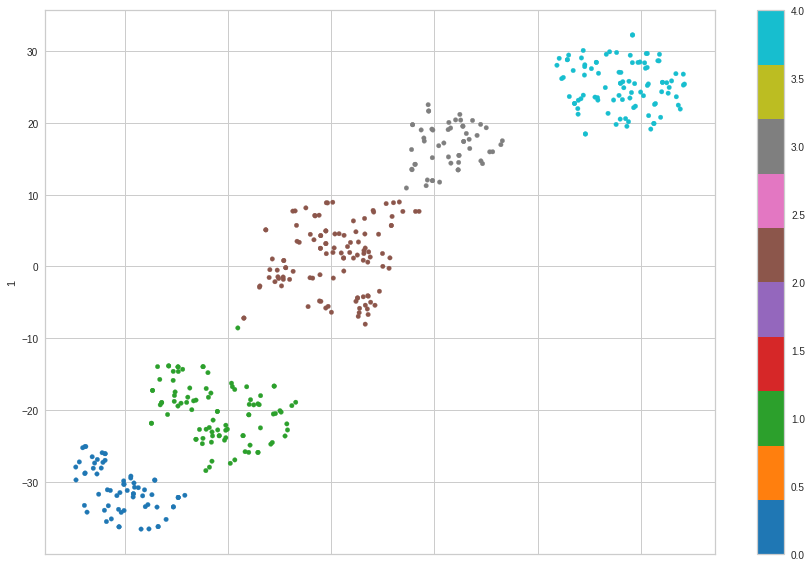

In [181]:
k_proto = KPrototypes(n_clusters=5, max_iter=100, init="Cao", n_init=10, random_state=0)
df_marketing_sub_segmentation_cluster_1["Sub_cluster_1_k_prototypes"] \
 = k_proto.fit_predict(df_marketing_sub_segmentation_cluster_1, 
                       categorical=categorical_features)

df_TSNE = TSNE(random_state=0).fit_transform(df_marketing_sub_segmentation_cluster_1)
pd.DataFrame(df_TSNE).plot.scatter(x=0, y=1, 
                                   c=df_marketing_sub_segmentation_cluster_1["Sub_cluster_1_k_prototypes"], 
                                   colormap='tab10', figsize=(15,10))
plt.show()

* Pelo t-sne, os clusters estão bem separados um do outro.
* Agora que o cluster 1 foi dividido em dois clusters, só preciso sumarizar

#### Preparar para sumarizar os sub-clusters

In [182]:
df_marketing_sub_segmentation_cluster_1_summary = df_marketing_sub_segmentation_cluster_1\
.groupby("Sub_cluster_1_k_prototypes").agg({"Age": lambda a:a.mean(),
                                            "NumDealsPurchases": lambda p:p.mean(),
                                            "MntWines": lambda w:w.mean(),
                                            "MntMeatProducts": lambda m:m.mean(),
                                            "NumDealsPurchases": lambda p:p.mean(),
                                            "MntWines": lambda w:w.mean(),
                                            "MntMeatProducts": lambda m:m.mean(),
                                            "Cat_kidhome": lambda k:k.mode(),
                                            "Cat_teenhome": lambda t:t.mode(),
                                            "High_num_catalog_purchases": lambda h:h.mode(),
                                            "Low_num_web_visits_month": lambda w:w.mode(),
                                            "AcceptedCmp1": lambda a:a.mode(),
                                            "AcceptedCmp2": lambda a:a.mode(),
                                            "AcceptedCmp3": lambda a:a.mode(),
                                            "AcceptedCmp4": lambda a:a.mode(),
                                            "AcceptedCmp5": lambda a:a.mode(),
                                            "Response": lambda a:a.mode()}).reset_index()

#### Cluster Padronizado para o experimento

In [183]:
df_marketing_sub_segmentation_cluster_1_summary

,Sub_cluster_1_k_prototypes,Age,NumDealsPurchases,MntWines,MntMeatProducts,Cat_kidhome,Cat_teenhome,High_num_catalog_purchases,Low_num_web_visits_month,AcceptedCmp1,AcceptedCmp2,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,Response
0,0,0.898148,-0.363636,0.945297,0.669753,False,False,False,True,False,False,False,False,False,False
1,1,0.670175,-0.342105,0.683333,1.619834,False,False,False,True,False,False,False,False,False,False
2,2,-0.511308,-0.411504,0.586689,1.140528,False,False,False,True,False,False,False,False,False,False
3,3,-0.077160,-0.509259,1.982446,1.106996,False,False,False,True,False,False,False,True,True,True
4,4,0.119385,0.345745,1.509353,0.733501,False,True,False,False,False,False,False,False,False,False


In [184]:
sub_clustering_0 = df_marketing_sub_segmentation_cluster_1_summary\
.loc[(df_marketing_sub_segmentation_cluster_1_summary["Age"]>0.8) \
     & (df_marketing_sub_segmentation_cluster_1_summary["Age"]<0.9), 
     "Sub_cluster_1_k_prototypes"]

df_marketing_sub_segmentation_cluster_1_summary\
.loc[(df_marketing_sub_segmentation_cluster_1_summary["Age"]>0.8) \
     & (df_marketing_sub_segmentation_cluster_1_summary["Age"]<0.9), 
     "Sub_cluster_1_k_prototypes"] = 0 

sub_clustering_1 = df_marketing_sub_segmentation_cluster_1_summary\
.loc[(df_marketing_sub_segmentation_cluster_1_summary["Age"]<0.8) \
     & (df_marketing_sub_segmentation_cluster_1_summary["Age"]>0.2), 
     "Sub_cluster_1_k_prototypes"]

df_marketing_sub_segmentation_cluster_1_summary\
.loc[(df_marketing_sub_segmentation_cluster_1_summary["Age"]>-0.43) \
     & (df_marketing_sub_segmentation_cluster_1_summary["Age"]<-0.44), 
     "Sub_cluster_1_k_prototypes"]=1

sub_clustering_2 = df_marketing_sub_segmentation_cluster_1_summary\
.loc[(df_marketing_sub_segmentation_cluster_1_summary["Age"]<-0.51) \
     & (df_marketing_sub_segmentation_cluster_1_summary["Age"]>-0.52), 
     "Sub_cluster_1_k_prototypes"]
                                                     
df_marketing_sub_segmentation_cluster_1_summary\
.loc[(df_marketing_sub_segmentation_cluster_1_summary["Age"]<-0.51) \
     & (df_marketing_sub_segmentation_cluster_1_summary["Age"]>-0.52), 
     "Sub_cluster_1_k_prototypes"]=2                                                    

sub_clustering_3 = df_marketing_sub_segmentation_cluster_1_summary\
.loc[(df_marketing_sub_segmentation_cluster_1_summary["Cat_teenhome"]==True), 
     "Sub_cluster_1_k_prototypes"]
                                                     
df_marketing_sub_segmentation_cluster_1_summary\
.loc[(df_marketing_sub_segmentation_cluster_1_summary["Cat_teenhome"]==True), 
     "Sub_cluster_1_k_prototypes"]=3

sub_clustering_4 = df_marketing_sub_segmentation_cluster_1_summary\
.loc[(df_marketing_sub_segmentation_cluster_1_summary["Response"]==True) \
     & (df_marketing_sub_segmentation_cluster_1_summary["AcceptedCmp5"]==True), 
     "Sub_cluster_1_k_prototypes"]
                                                     
df_marketing_sub_segmentation_cluster_1_summary\
.loc[(df_marketing_sub_segmentation_cluster_1_summary["Response"]==True) \
     & (df_marketing_sub_segmentation_cluster_1_summary["AcceptedCmp5"]==True), 
     "Sub_cluster_1_k_prototypes"]=4

In [185]:
df_marketing_sub_segmentation_cluster_1_summary = df_marketing_sub_segmentation_cluster_1_summary\
.sort_values(by="Sub_cluster_1_k_prototypes").set_index("Sub_cluster_1_k_prototypes")

#### Sumarizar sub-clusters

In [186]:
df_marketing_sub_segmentation_cluster_1_summary.info()

<class 'pandas.core.frame.DataFrame'>
UInt64Index: 5 entries, 0 to 4
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Age                         5 non-null      float64
 1   NumDealsPurchases           5 non-null      float64
 2   MntWines                    5 non-null      float64
 3   MntMeatProducts             5 non-null      float64
 4   Cat_kidhome                 5 non-null      bool   
 5   Cat_teenhome                5 non-null      bool   
 6   High_num_catalog_purchases  5 non-null      bool   
 7   Low_num_web_visits_month    5 non-null      bool   
 8   AcceptedCmp1                5 non-null      bool   
 9   AcceptedCmp2                5 non-null      bool   
 10  AcceptedCmp3                5 non-null      bool   
 11  AcceptedCmp4                5 non-null      bool   
 12  AcceptedCmp5                5 non-null      bool   
 13  Response                    5 non-null

In [187]:
df_marketing_sub_segmentation_cluster_1_summary

,Age,NumDealsPurchases,MntWines,MntMeatProducts,Cat_kidhome,Cat_teenhome,High_num_catalog_purchases,Low_num_web_visits_month,AcceptedCmp1,AcceptedCmp2,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,Response
Sub_cluster_1_k_prototypes,,,,,,,,,,,,,,
0,0.898148,-0.363636,0.945297,0.669753,False,False,False,True,False,False,False,False,False,False
1,0.670175,-0.342105,0.683333,1.619834,False,False,False,True,False,False,False,False,False,False
2,-0.511308,-0.411504,0.586689,1.140528,False,False,False,True,False,False,False,False,False,False
3,0.119385,0.345745,1.509353,0.733501,False,True,False,False,False,False,False,False,False,False
4,-0.077160,-0.509259,1.982446,1.106996,False,False,False,True,False,False,False,True,True,True


In [188]:
(df_marketing_sub_segmentation_cluster_1[df_marketing_sub_segmentation_cluster_1\
                                        ["Sub_cluster_1_k_prototypes"]==4].shape[0]/2237)*100

4.202056325435851

* O sub-cluster 4 foi o mais fiel dentre os sub-clusters e clusters identificados. Foi o único que, na moda, aceitou a oferta na última campanha, na quinta e na quarta.
* Esse sub-cluster tem 51 clientes na base, isso é igual a **2.28%** dos clientes totais.

In [189]:
df_marketing_sub_segmentation_cluster_1.head(3)

,Age,Cat_kidhome,Cat_teenhome,MntWines,MntMeatProducts,NumDealsPurchases,High_num_catalog_purchases,Low_num_web_visits_month,AcceptedCmp1,AcceptedCmp2,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,Response,Cluster_k_prototypes,Sub_cluster_1_k_prototypes
2,0.277778,False,False,0.525000,0.277778,-0.5,False,True,False,False,False,False,False,False,1,0
12,0.611111,False,False,0.041667,1.912037,-0.5,False,True,False,False,False,False,False,False,1,1
15,1.333333,False,False,1.733333,0.222222,-0.5,False,True,True,False,False,False,True,True,1,0


## Criar dataset df_marketing_segmentation_full

In [243]:
df_marketing_segmentation_full = pd.merge(df_marketing_segmentation.reset_index(), 
                                          df_marketing_sub_segmentation_cluster_1.reset_index()\
                                          [["index", "Sub_cluster_1_k_prototypes"]], 
                                          how="left",
                                          on="index").set_index("index")

In [244]:
df_marketing_segmentation_full.drop("multi_class", axis=1, inplace=True)

In [245]:
df_marketing_segmentation_full.head(3)

,Age,Cat_kidhome,Cat_teenhome,MntWines,MntMeatProducts,NumDealsPurchases,High_num_catalog_purchases,Low_num_web_visits_month,AcceptedCmp1,AcceptedCmp2,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,Response,Cluster_k_prototypes,Sub_cluster_1_k_prototypes
index,,,,,,,,,,,,,,,,
0,0.722222,False,False,0.960417,2.217593,0.5,True,False,False,False,False,False,False,True,4,NaN
1,0.888889,True,True,-0.339583,-0.282407,0.0,False,False,False,False,False,False,False,False,2,NaN
2,0.277778,False,False,0.525000,0.277778,-0.5,False,True,False,False,False,False,False,False,1,0.0


In [246]:
df_marketing_segmentation_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2237 entries, 0 to 2239
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Age                         2237 non-null   float64
 1   Cat_kidhome                 2237 non-null   bool   
 2   Cat_teenhome                2237 non-null   bool   
 3   MntWines                    2237 non-null   float64
 4   MntMeatProducts             2237 non-null   float64
 5   NumDealsPurchases           2237 non-null   float64
 6   High_num_catalog_purchases  2237 non-null   bool   
 7   Low_num_web_visits_month    2237 non-null   bool   
 8   AcceptedCmp1                2237 non-null   bool   
 9   AcceptedCmp2                2237 non-null   bool   
 10  AcceptedCmp3                2237 non-null   bool   
 11  AcceptedCmp4                2237 non-null   bool   
 12  AcceptedCmp5                2237 non-null   bool   
 13  Response                    2237 

In [247]:
df_marketing_segmentation_full["Cluster_k_prototypes"]\
=df_marketing_segmentation_full["Cluster_k_prototypes"].astype(object)

df_marketing_segmentation_full["Sub_cluster_1_k_prototypes"]\
=df_marketing_segmentation_full["Sub_cluster_1_k_prototypes"].astype(object)

In [248]:
df_marketing_segmentation_full.loc[df_marketing_segmentation_full["Sub_cluster_1_k_prototypes"].isnull(),
                                   'Sub_cluster_1_k_prototypes'] = -1

## Análise do cluster pelo método do cotovelo

In [249]:
categorical_features = [1, 2, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

In [250]:
# Não rodar múltiplas vezes pelo custo computacional
%%script echo skipping
# Fitando vários modelos e armazenando inércia na lista SSE
SSE = []
for cluster in range(2, 20):  
  k_proto = KPrototypes(n_clusters=cluster, max_iter=100, init="Cao", n_init=10, random_state=0)
  k_proto.fit(df_marketing_segmentation_full, categorical=categorical_features)
  SSE.append(k_proto.cost_)

# Convertendo os resultados em um dataframe
frame = pd.DataFrame({'Cluster': range(2, 20),
                      'SSE': SSE})
plt.figure(figsize=(5, 5))
plt.plot(frame['Cluster'], frame['SSE'], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.savefig("cotovelo_segmentation.jpg")

skipping


![](https://drive.google.com/uc?export=view&id=1arK1KCN7F1YlD2uNS1kh6rVIEZpX6fEh)

## Análise do cluster pelo método da silhueta escore

In [251]:
# Não rodar múltiplas vezes pelo custo computacional
%%script echo skipping
# Fitando vários modelos e armazenando inércia na lista SSE
SSE = []
for cluster in range(2, 10):  
  k_proto = KPrototypes(n_clusters=cluster, max_iter=100, init="Cao", n_init=10, random_state=0)
  label = k_proto.fit_predict(df_marketing_segmentation_full, categorical=categorical_features)
  SSE.append(silhouette_score(df_marketing_segmentation_full, label))

# Convertendo os resultados em um dataframe
frame = pd.DataFrame({'Cluster': range(2, 10),
                      'SSE': SSE})
plt.figure(figsize=(5, 5))
plt.plot(frame['Cluster'], frame['SSE'], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.savefig("silhueta_segment.jpg")

skipping


![](https://drive.google.com/uc?export=view&id=1tbWnpWOBg8Nc_lArzKMpap2MfJM7cjTz)

* Se compararmos a última com a primeira clusterização, veremos que o silhueta escore performou incrivelmente bem entre 2 e 8.
* A quantidade de cluster com maior silhueta escore foi o 5 com 0.46.
* O segundo com a maior silhueta escore foi o 2 com 0.45. 
* O terceiro foi o 7 com 0.44.
* Irei selecionar 5 clusters.

## Visualização por t-sne

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


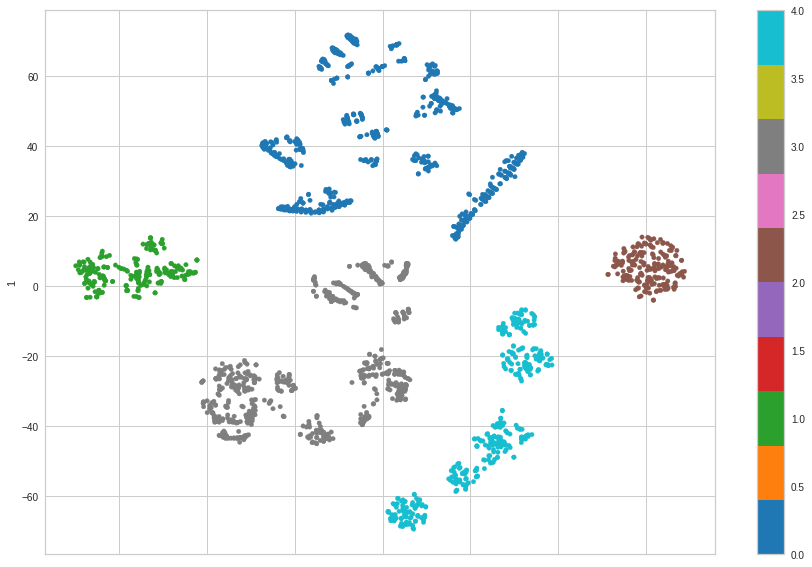

In [252]:
k_proto = KPrototypes(n_clusters=5, max_iter=100, init="Cao", n_init=10, random_state=0)
df_marketing_segmentation_full["Segment_k_prototypes"] \
 = k_proto.fit_predict(df_marketing_segmentation_full, 
                       categorical=categorical_features)
 
df_TSNE = TSNE(random_state=0).fit_transform(df_marketing_segmentation_full)
pd.DataFrame(df_TSNE).plot.scatter(x=0, y=1, 
                                   c=df_marketing_segmentation_full["Segment_k_prototypes"], 
                                   colormap='tab10', figsize=(15,10))

* Pela visualização t-sne, os clusters estão bem separados um do outro! Incrível!
* O conceito de sabedoria das multidões deu certo! Os Dois k-prototypes treinados para encontrar os grupos gerais e os subgrupos do 1, deram pistas para o terceiro k-prototypes separar bem os grupos.

In [253]:
df_marketing_segmentation_full.groupby("Segment_k_prototypes").agg({"Age": lambda a:a.mean(),
                                            "NumDealsPurchases": lambda p:p.mean(),
                                            "MntWines": lambda w:w.mean(),
                                            "MntMeatProducts": lambda m:m.mean(),
                                            "NumDealsPurchases": lambda p:p.mean(),
                                            "MntWines": lambda w:w.mean(),
                                            "MntMeatProducts": lambda m:m.mean(),
                                            "Cat_kidhome": lambda k:k.mode(),
                                            "Cat_teenhome": lambda t:t.mode(),
                                            "High_num_catalog_purchases": lambda h:h.mode(),
                                            "Low_num_web_visits_month": lambda w:w.mode(),
                                            "AcceptedCmp1": lambda a:a.mode(),
                                            "AcceptedCmp2": lambda b:b.mode(),
                                            "AcceptedCmp3": lambda c:c.mode(),
                                            "AcceptedCmp4": lambda d:d.mode(),
                                            "AcceptedCmp5": lambda e:e.mode(),
                                            "Response": lambda f:f.mode()}).reset_index()

,Segment_k_prototypes,Age,NumDealsPurchases,MntWines,MntMeatProducts,Cat_kidhome,Cat_teenhome,High_num_catalog_purchases,Low_num_web_visits_month,AcceptedCmp1,AcceptedCmp2,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,Response
0,0,-0.461079,-0.094477,-0.274849,-0.176464,True,False,False,False,False,False,False,False,False,False
1,1,0.145299,2.281377,0.403568,0.350146,True,True,False,False,False,False,False,False,False,False
2,2,0.002883,-0.523585,1.002300,2.951935,False,False,False,True,False,False,False,False,False,False
3,3,0.516467,0.113772,0.060220,-0.017659,False,True,False,False,False,False,False,False,False,False
4,4,0.171143,-0.232227,1.048657,1.079845,False,False,False,True,False,False,False,False,False,False


* A silhueta escore melhorou bastante!
* Porém, ainda não encontrei o centróide que responde a pergunta do cliente que aceitou mais ofertas de campanha.
* Outro ponto importante, na coluna High_num_catalog_purchases não teve insights significativos, assim irei trocar para a variável original NumCatalogPurchases. 
* E se eu transformar as variáveis AcceptedCmp e a variável Response em uma soma de campanhas aceitas?

## Pré-Processamento 03

In [254]:
df_marketing_preprocessing_03 = df_marketing_segmentation_full.copy()

### Substituir o High_num_catalog_purchases pela variável NumCatalogPurchases.

* Aplicar a função **merge()** para colocar a coluna **NumCatalogPurchases**.

In [255]:
df_marketing_preprocessing_03 = pd.merge(df_marketing_segmentation_full.reset_index(),
                                         df_marketing_preprocessing_01.reset_index()[["index", "NumCatalogPurchases"]],
                                         how="left",
                                         on="index").set_index("index")

* Remover a coluna High_num_catalog_purchases.

In [256]:
df_marketing_preprocessing_03.drop("High_num_catalog_purchases", axis=1, inplace=True)

### Feature Engineering: NumAcceptedCmp

* Criar variável **NumAcceptedCmp**, porque não foi possível identificar o cliente que mais aceita ofertas das campanhas.

In [257]:
df_marketing_preprocessing_03["NumAcceptedCmp"]\
 = (df_marketing_preprocessing_03["AcceptedCmp1"]\
 + df_marketing_preprocessing_03["AcceptedCmp2"]\
 + df_marketing_preprocessing_03["AcceptedCmp3"]\
 + df_marketing_preprocessing_03["AcceptedCmp4"]\
 + df_marketing_preprocessing_03["AcceptedCmp5"]\
 + df_marketing_preprocessing_03["Response"]).astype(int)

### Normalizar as variáveis NumCatalogPurchases e NumAcceptedCmp.

In [258]:
df_marketing_preprocessing_03.describe(percentiles=[.25, .50, .75, .99])

,Age,MntWines,MntMeatProducts,NumDealsPurchases,Segment_k_prototypes,NumCatalogPurchases,NumAcceptedCmp
count,2237.000000,2237.000000,2237.000000,2237.000000,2237.000000,2237.000000,2237.000000
mean,0.061019,0.270824,0.462578,0.163388,1.950380,2.662494,0.271793
std,0.650107,0.701197,1.044728,0.966462,1.546751,2.923456,0.444983
min,-1.444444,-0.362500,-0.310185,-1.000000,0.000000,0.000000,0.000000
25%,-0.388889,-0.312500,-0.236111,-0.500000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,2.000000,2.000000,0.000000
75%,0.611111,0.687500,0.763889,0.500000,3.000000,4.000000,1.000000
99%,1.388889,2.314583,3.925926,4.000000,4.000000,10.640000,1.000000
max,1.666667,2.747917,7.675926,6.500000,4.000000,28.000000,1.000000


* Normalizar por RobustScaler() para manter o padrão de normalização já feita.

In [259]:
# Armazenar o interquartil e a mediana do NumCatalogPurchases
Q1_NumCatalogPurchases = 0
Q3_NumCatalogPurchases = 4
Median_NumCatalogPurchases = df_marketing_preprocessing_03["NumCatalogPurchases"].median()

# Armazenar o interquartil e a mediana do NumAcceptedCmp
Q1_NumAcceptedCmp = 0
Q3_NumAcceptedCmp = 1
Median_NumAcceptedCmp = df_marketing_preprocessing_03["NumAcceptedCmp"].median()

In [260]:
# Computar a fórmula do RobustScaler
df_marketing_preprocessing_03[["NumCatalogPurchases"]]\
 = (df_marketing_preprocessing_03[["NumCatalogPurchases"]] - Median_NumCatalogPurchases)\
 /(Q3_NumCatalogPurchases-Q1_NumCatalogPurchases)

df_marketing_preprocessing_03[["NumAcceptedCmp"]]\
 = (df_marketing_preprocessing_03[["NumAcceptedCmp"]] - Median_NumAcceptedCmp)/(Q3_NumAcceptedCmp-Q1_NumAcceptedCmp)

In [261]:
df_marketing_preprocessing_03.describe()

,Age,MntWines,MntMeatProducts,NumDealsPurchases,Segment_k_prototypes,NumCatalogPurchases,NumAcceptedCmp
count,2237.000000,2237.000000,2237.000000,2237.000000,2237.000000,2237.000000,2237.000000
mean,0.061019,0.270824,0.462578,0.163388,1.950380,0.165624,0.271793
std,0.650107,0.701197,1.044728,0.966462,1.546751,0.730864,0.444983
min,-1.444444,-0.362500,-0.310185,-1.000000,0.000000,-0.500000,0.000000
25%,-0.388889,-0.312500,-0.236111,-0.500000,0.000000,-0.500000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000
75%,0.611111,0.687500,0.763889,0.500000,3.000000,0.500000,1.000000
max,1.666667,2.747917,7.675926,6.500000,4.000000,6.500000,1.000000


In [262]:
df_marketing_preprocessing_03.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2237 entries, 0 to 2239
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Age                         2237 non-null   float64
 1   Cat_kidhome                 2237 non-null   bool   
 2   Cat_teenhome                2237 non-null   bool   
 3   MntWines                    2237 non-null   float64
 4   MntMeatProducts             2237 non-null   float64
 5   NumDealsPurchases           2237 non-null   float64
 6   Low_num_web_visits_month    2237 non-null   bool   
 7   AcceptedCmp1                2237 non-null   bool   
 8   AcceptedCmp2                2237 non-null   bool   
 9   AcceptedCmp3                2237 non-null   bool   
 10  AcceptedCmp4                2237 non-null   bool   
 11  AcceptedCmp5                2237 non-null   bool   
 12  Response                    2237 non-null   bool   
 13  Cluster_k_prototypes        2237 

In [263]:
categorical_features = [1, 2, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

## Análise do cluster pelo método do cotovelo

In [268]:
# Não rodar múltiplas vezes pelo custo computacional
%%script echo skipping
# Fitando vários modelos e armazenando inércia na lista SSE
SSE = []
for cluster in range(2, 10):  
  k_proto = KPrototypes(n_clusters=cluster, max_iter=100, init="Cao", n_init=10, random_state=0)
  k_proto.fit(df_marketing_preprocessing_03, categorical=categorical_features)
  SSE.append(k_proto.cost_)

# Convertendo os resultados em um dataframe
frame = pd.DataFrame({'Cluster': range(2, 10),
                      'SSE': SSE})
plt.figure(figsize=(5, 5))
plt.plot(frame['Cluster'], frame['SSE'], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.savefig("cotovelo_segmentation_NumAcceptedCmp.jpg")

skipping


![](https://drive.google.com/uc?export=view&id=1iTj2cAO31wCC9LS-hwYjzF_VJTUO1wBj)

* A curva da Inércia está com um comportamento de estabilidade a partir de 5.

## Análise do cluster pelo método da silhueta escore

In [267]:
# Não rodar múltiplas vezes pelo custo computacional
%%script echo skipping
# Fitando vários modelos e armazenando inércia na lista SSE
SSE = []
for cluster in range(2, 10):  
  k_proto = KPrototypes(n_clusters=cluster, max_iter=100, init="Cao", n_init=10, random_state=0)
  label = k_proto.fit_predict(df_marketing_preprocessing_03, categorical=categorical_features)
  SSE.append(silhouette_score(df_marketing_preprocessing_03, label))

# Convertendo os resultados em um dataframe
frame = pd.DataFrame({'Cluster': range(2, 10),
                      'SSE': SSE})
plt.figure(figsize=(5, 5))
plt.plot(frame['Cluster'], frame['SSE'], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.savefig("silhueta_segment_NumAcceptedCmp.jpg")

skipping


![](https://drive.google.com/uc?export=view&id=16dP7-FW7ws5r9__DUdwyA8cm9xGvT6Oa)

* O maior silhueta escore é 0.5 com 5 clusters.
* O segundo maior foi o 6 com 0.48.
* Pelo método do cotovelo e silhueta escore, decidi usar 5 clusters. 

## Visualizar o número de clusters por t-sne

In [210]:
categorical_features = [1, 2, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]


In [270]:
# Não rodar múltiplas vezes pelo custo computacional
%%script echo skipping

k_proto = KPrototypes(n_clusters=5, max_iter=100, init="Cao", n_init=10, random_state=0)
df_marketing_preprocessing_03["Segment_k_prototypes_NumAcceptedCmp"] \
 = k_proto.fit_predict(df_marketing_preprocessing_03, 
                       categorical=categorical_features)
 
df_TSNE = TSNE(random_state=0).fit_transform(df_marketing_preprocessing_03)
pd.DataFrame(df_TSNE).plot.scatter(x=0, y=1, 
                                   c=df_marketing_preprocessing_03["Segment_k_prototypes_NumAcceptedCmp"], 
                                   colormap='tab10', figsize=(15,10))
plt.savefig("tsne_NumAccepted.jpg")

skipping


![](https://drive.google.com/uc?export=view&id=123BumWvZmUxKJ6TupVbDvbQYnqeS6-LJ)

* Houve uma separação ótima com 5 clusters.
* O cluster 0 e 1 apresentam a maior distância intracluster.

## Padronização dos resultados do K-Prototypes

In [271]:
k_proto = KPrototypes(n_clusters=5, max_iter=100, init="Cao", n_init=10, random_state=0)
df_marketing_preprocessing_03["Segment_k_prototypes_NumAcceptedCmp"] \
 = k_proto.fit_predict(df_marketing_preprocessing_03, 
                       categorical=categorical_features)

In [272]:
df_marketing_segmentation_full_summary\
 = df_marketing_preprocessing_03.groupby("Segment_k_prototypes_NumAcceptedCmp")\
.agg({"Age": lambda a:a.mean(),
"NumDealsPurchases": lambda p:p.mean(),
"MntWines": lambda w:w.mean(),
"MntMeatProducts": lambda m:m.mean(),
"NumDealsPurchases": lambda p:p.mean(),
"MntWines": lambda w:w.mean(),
"MntMeatProducts": lambda m:m.mean(),
"Cat_kidhome": lambda k:k.mode(),
"Cat_teenhome": lambda t:t.mode(),
"NumCatalogPurchases": lambda h:h.mean(),
"Low_num_web_visits_month": lambda w:w.mode(),
"AcceptedCmp1": lambda a:a.mode(),
"AcceptedCmp2": lambda b:b.mode(),
"AcceptedCmp3": lambda c:c.mode(),
"AcceptedCmp4": lambda d:d.mode(),
"AcceptedCmp5": lambda e:e.mode(),
"Response": lambda f:f.mode(),
"NumAcceptedCmp": lambda g:g.mean()}).reset_index()

In [273]:
segmentation_clustering_0 = df_marketing_segmentation_full_summary\
.loc[(df_marketing_segmentation_full_summary["Low_num_web_visits_month"]==True) \
     & (df_marketing_segmentation_full_summary["Age"]<0.1), 
     "Segment_k_prototypes_NumAcceptedCmp"]

df_marketing_segmentation_full_summary\
.loc[(df_marketing_segmentation_full_summary["Low_num_web_visits_month"]==True) \
     & (df_marketing_segmentation_full_summary["Age"]<0.1), 
     "Segment_k_prototypes_NumAcceptedCmp"] = 0 

In [274]:
segmentation_clustering_1 = df_marketing_segmentation_full_summary\
.loc[(df_marketing_segmentation_full_summary["Cat_kidhome"]==True) \
     & (df_marketing_segmentation_full_summary["Cat_teenhome"]==True), 
     "Segment_k_prototypes_NumAcceptedCmp"]

df_marketing_segmentation_full_summary\
.loc[(df_marketing_segmentation_full_summary["Cat_kidhome"]==True) \
     & (df_marketing_segmentation_full_summary["Cat_teenhome"]==True), 
     "Segment_k_prototypes_NumAcceptedCmp"]=1

In [275]:
segmentation_clustering_2 = df_marketing_segmentation_full_summary\
.loc[(df_marketing_segmentation_full_summary["Cat_kidhome"]==True) \
     & (df_marketing_segmentation_full_summary["Cat_teenhome"]==False), 
     "Segment_k_prototypes_NumAcceptedCmp"]
                                                     
df_marketing_segmentation_full_summary\
.loc[(df_marketing_segmentation_full_summary["Cat_kidhome"]==True) \
     & (df_marketing_segmentation_full_summary["Cat_teenhome"]==False), 
     "Segment_k_prototypes_NumAcceptedCmp"]=2  

In [276]:
segmentation_clustering_3 = df_marketing_segmentation_full_summary\
.loc[(df_marketing_segmentation_full_summary["Cat_kidhome"]==False) \
     & (df_marketing_segmentation_full_summary["Cat_teenhome"]==True), 
     "Segment_k_prototypes_NumAcceptedCmp"]
                                                     
df_marketing_segmentation_full_summary\
.loc[(df_marketing_segmentation_full_summary["Cat_kidhome"]==False) \
     & (df_marketing_segmentation_full_summary["Cat_teenhome"]==True), 
     "Segment_k_prototypes_NumAcceptedCmp"]=3

In [277]:
segmentation_clustering_4 = df_marketing_segmentation_full_summary\
.loc[(df_marketing_segmentation_full_summary["Low_num_web_visits_month"]==True) \
     & (df_marketing_segmentation_full_summary["Age"]>0.1), 
     "Segment_k_prototypes_NumAcceptedCmp"]
                                                     
df_marketing_segmentation_full_summary\
.loc[(df_marketing_segmentation_full_summary["Low_num_web_visits_month"]==True) \
     & (df_marketing_segmentation_full_summary["Age"]>0.1), 
     "Segment_k_prototypes_NumAcceptedCmp"]=4

In [278]:
df_marketing_segmentation_full_summary = df_marketing_segmentation_full_summary.set_index("Segment_k_prototypes_NumAcceptedCmp")

In [281]:
df_marketing_segmentation_full_summary.sort_values(by="Segment_k_prototypes_NumAcceptedCmp")

,Age,NumDealsPurchases,MntWines,MntMeatProducts,Cat_kidhome,Cat_teenhome,NumCatalogPurchases,Low_num_web_visits_month,AcceptedCmp1,AcceptedCmp2,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,Response,NumAcceptedCmp
Segment_k_prototypes_NumAcceptedCmp,,,,,,,,,,,,,,,
0,-0.003359,-0.425581,0.983992,3.012554,False,False,1.161628,True,False,False,False,False,False,False,0.600000
1,0.152550,2.229508,0.412338,0.264743,True,True,0.158811,False,False,False,False,False,False,False,0.299180
2,-0.458333,-0.092105,-0.279368,-0.178769,True,False,-0.358918,False,False,False,False,False,False,False,0.154971
3,0.513142,0.113671,0.045440,-0.030480,False,True,-0.108679,False,False,False,False,False,False,False,0.149002
4,0.179333,-0.221219,1.027474,1.048784,False,False,0.898984,True,False,False,False,False,False,False,0.458239


##Retransformar as variáveis numéricas

In [282]:
df_marketing_segmentation_full_summary["Age"]\
 = df_marketing_segmentation_full_summary["Age"]*(Q3_Age - Q1_Age) + Median_Age

df_marketing_segmentation_full_summary["NumDealsPurchases"]\
 = df_marketing_segmentation_full_summary["NumDealsPurchases"]*(Q3_NumDealsPurchases - Q1_NumDealsPurchases)\
+ Median_NumDealsPurchases

df_marketing_segmentation_full_summary["MntWines"]\
 = df_marketing_segmentation_full_summary["MntWines"]*(Q3_MntWines - Q1_MntWines)\
+ Median_MntWines

df_marketing_segmentation_full_summary["MntMeatProducts"]\
 = df_marketing_segmentation_full_summary["MntMeatProducts"]*(Q3_MntMeatProducts - Q1_MntMeatProducts)\
+ Median_MntMeatProducts

df_marketing_segmentation_full_summary["NumCatalogPurchases"]\
 = df_marketing_segmentation_full_summary["NumCatalogPurchases"]*(Q3_NumCatalogPurchases - Q1_NumCatalogPurchases)\
+ Median_NumCatalogPurchases

df_marketing_segmentation_full_summary["NumAcceptedCmp"]\
 = df_marketing_segmentation_full_summary["NumAcceptedCmp"]*(Q3_NumAcceptedCmp - Q1_NumAcceptedCmp)\
+ Median_NumAcceptedCmp

## Conclusão




In [283]:
df_marketing_segmentation_full_summary.sort_values(by='Segment_k_prototypes_NumAcceptedCmp')

,Age,NumDealsPurchases,MntWines,MntMeatProducts,Cat_kidhome,Cat_teenhome,NumCatalogPurchases,Low_num_web_visits_month,AcceptedCmp1,AcceptedCmp2,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,Response,NumAcceptedCmp
Segment_k_prototypes_NumAcceptedCmp,,,,,,,,,,,,,,,
0,51.939535,1.148837,646.316279,717.711628,False,False,6.646512,True,False,False,False,False,False,False,0.600000
1,54.745902,6.459016,371.922131,124.184426,True,True,2.635246,False,False,False,False,False,False,False,0.299180
2,43.750000,1.815789,39.903509,28.385965,True,False,0.564327,False,False,False,False,False,False,False,0.154971
3,61.236559,2.227343,195.811060,60.416283,False,True,1.565284,False,False,False,False,False,False,False,0.149002
4,55.227991,1.557562,667.187359,293.537246,False,False,5.595937,True,False,False,False,False,False,False,0.458239


* Perguntas a serem respondidas:
  * Quem mais aceitou ofertas?
    * O cluster 0 aceitou mais ofertas. Na média deu 0.6, quase uma campanha.
    * O segundo foi o cluster 4 que aceitou, na média, 0.45 campanhas.
  * Quem é o mais jovem?
    * O cluster 2 é o mais jovem com 44 anos.
  * Quem é o mais velho?
    * O cluster 3 é o mais velho com 61 anos.
  * Quem não tem filhos?
    * O cluster 0 e 4 não têm filhos.
  * Quem menos visita o site por mês?
    * O cluster 0 e 4 menos visitam o site por mês.
  * Quem mais compra pelo catálogo?
    * O cluster 0 comprou 7 unidades pelo catálogo.
    * O cluster 4 comprou 6 unidades pelo catálogo.
  * Quem gosta mais de desconto?
    * O cluster 1 é o que mais gosta de comprar com desconto.
  * Quem gosta mais de vinho?
    * O cluster 4 gosta muito de vinho, gastando 677 Unidades Monetárias nos últimos dois anos.
    * O cluster 0 adora vinho, gastando 655 Unidades Monetárias mos últimos dois anos.
  * Quem gosta mais de carne?
    * O cluster 0 gosta muito de carne, gastando 704 Unidades Monetárias nos últimos dois anos.
    * O cluster 4 também gosta muito de carne, gastando 300 Unidades Monetárias nos últimos dois anos.

* Uma sugestão para a equipe de marketing é considerar as características encontradas no cluster 0 e 4 nas próximas campanhas, porque foram os segmentos que mais aceitaram ofertas de campanha. E quais são essas características?
* Pessoas que compram muita carne e vinho, entre 300 e 704MU de gastos nos últimos dois anos, não tem filhos, visitaram pouco o site da plataforma no último mês, abaixo de 6 visitas, e compraram entre 6 e 7 unidades pelo catálogo. 
  